
IMPORT LIBRARIES AND DATASET

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression  
from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('loan_data_2007_2014.csv', low_memory=False)

In [3]:
df.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


DATA UNDERSTANDING

---

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [5]:
df.duplicated().sum()

0

In [6]:
missing_values = df.isnull().sum()
total_rows = len(df)

missing_percent = (missing_values / total_rows) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage (%)': missing_percent
})

pd.set_option('display.width', None)
missing_df.sort_values(by='Missing Percentage (%)', ascending=False).head(25)

,Missing Values,Missing Percentage (%)
inq_last_12m,466285,100.000000
total_bal_il,466285,100.000000
dti_joint,466285,100.000000
verification_status_joint,466285,100.000000
annual_inc_joint,466285,100.000000
open_acc_6m,466285,100.000000
open_il_6m,466285,100.000000
open_il_12m,466285,100.000000
open_il_24m,466285,100.000000
mths_since_rcnt_il,466285,100.000000


In [7]:
# Filter kolom dengan missing value > 40%
drop1 = missing_percent[missing_percent > 40.0].index
df = df.drop(columns=drop1)

In [8]:
drop2 = ['Unnamed: 0','id','member_id','url','sub_grade','zip_code']
df.drop(drop2, axis=1, inplace= True)

Assigning the Target Column to Identify Bad Loans

---

In [9]:
df.loan_status.value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [10]:
# create a new column based on the loan_status column that will be our target variable
df['bad_loan'] = np.where(df.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                        'Does not meet the credit policy. Status:Charged Off']), 0, 1)

# Drop the original 'loan_status' column
df.drop(columns = ['loan_status'], inplace = True)

<AxesSubplot:ylabel='bad_loan'>

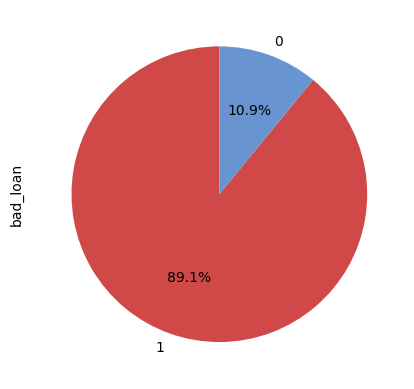

In [11]:
df['bad_loan'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#D04848','#6895D2'])

DATA PREPROCESSING

---

- term

In [12]:
df['term'].value_counts()

 36 months    337953
 60 months    128332
Name: term, dtype: int64

In [13]:
def term_numeric(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))
    
term_numeric(df, 'term')

In [14]:
df['term'].dtype

dtype('int64')

- emp_length_convert

In [15]:
# converting emp_length to numeric and assign NaN to zero
df['emp_length_int'] = df['emp_length']

def emp_length_convert(df, column):
    # Step 1: Convert special cases using regex
    df[column] = df[column].str.replace(r'^10\+ years$', '10', regex=True)
    df[column] = df[column].str.replace(r'^< 1 year$', '0', regex=True)
    df[column] = df[column].str.replace(r'^n/a$', '0', regex=True)
    
    # Step 2: Extract numbers from remaining values
    df[column] = df[column].str.extract(r'(\d+)', expand=False)
    
    # Step 3: Convert to numeric and handle missing values
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df[column].fillna(0, inplace=True)
    df[column] = df[column].astype(float)
    
emp_length_convert(df, 'emp_length_int')

In [16]:
df['emp_length_int'].unique()

array([10.,  0.,  1.,  3.,  8.,  9.,  4.,  5.,  6.,  2.,  7.])

In [17]:
df.drop('emp_length', axis=1, inplace=True)

- issue_d, 
- earliest_cr_line, 
- last_pymnt_d, 
- last_credit_pull_d

In [18]:
df_time = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']

In [19]:

for i in df_time:
    df[i] = pd.to_datetime(df[i], format='%b-%y')

df.select_dtypes('datetime64').describe()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
count,466285,466256,465909,466243
unique,91,664,98,103
top,2014-10-01 00:00:00,2000-10-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
freq,38782,3674,179620,327699
first,2007-06-01 00:00:00,1969-01-01 00:00:00,2007-12-01 00:00:00,2007-05-01 00:00:00
last,2014-12-01 00:00:00,2068-12-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00


In [20]:
# Define reference date
end_date = pd.to_datetime('2017-12-01')

# List of datetime columns
df_time = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

# Convert to months since end_date and rename columns
df_time_new = ['mnth_since_' + col for col in df_time]

# Loop through each datetime column and compute months difference
for old_col, new_col in zip(df_time, df_time_new):
    df[new_col] = round(pd.to_numeric((end_date - df[old_col]) / np.timedelta64(1, 'M')))

In [21]:
df.loc[df['mnth_since_earliest_cr_line']<0, 'mnth_since_earliest_cr_line'] = df['mnth_since_earliest_cr_line'].max()

In [22]:
df[['mnth_since_issue_d','mnth_since_earliest_cr_line' ,'mnth_since_last_pymnt_d','mnth_since_last_credit_pull_d']].describe(include="all")

,mnth_since_issue_d,mnth_since_earliest_cr_line,mnth_since_last_pymnt_d,mnth_since_last_credit_pull_d
count,466285.000000,466256.000000,465909.000000,466243.000000
mean,51.255187,242.385374,31.294369,27.045588
std,14.340154,86.460310,12.809898,9.636423
min,36.000000,73.000000,23.000000,23.000000
25%,41.000000,184.000000,23.000000,23.000000
50%,47.000000,226.000000,24.000000,23.000000
75%,57.000000,285.000000,35.000000,25.000000
max,126.000000,587.000000,120.000000,127.000000


In [23]:
# drop old time columns
df.drop(df_time, axis=1, inplace=True)

CHECK LABELS

---

In [24]:
# seperating categorical features from numerical
categorical_features = df.select_dtypes(exclude='number')
numerical_features = df.select_dtypes(exclude='object')

In [25]:
categorical_features.nunique().sort_values(ascending=False)

emp_title              205475
title                   63099
addr_state                 50
purpose                    14
grade                       7
home_ownership              6
verification_status         3
pymnt_plan                  2
initial_list_status         2
application_type            1
dtype: int64

In [26]:
summary = []
for col in numerical_features.columns:
    nunique = numerical_features[col].nunique(dropna=True)
    most_freq_count = numerical_features[col].value_counts(dropna=True).max()
    summary.append({'column': col, 'nunique': nunique, 'value_count': most_freq_count})

pd.DataFrame(summary)

,column,nunique,value_count
0,loan_amnt,1352,33023
1,funded_amnt,1354,32930
2,funded_amnt_inv,9854,28683
3,term,2,337953
4,int_rate,506,15846
5,installment,55622,1246
6,annual_inc,31901,17980
7,dti,3997,410
8,delinq_2yrs,24,382954
9,inq_last_6mths,28,241498


In [27]:
# deleting columns with Multicolliear Features
drop3 = ['policy_code', 'application_type', 'emp_title', 'title', 'pymnt_plan']

df.drop(drop3, axis=1, inplace=True)

MISSING VALUES

---

In [28]:
preprocess_data = df

#checking for any missing values
missing = preprocess_data.isnull().sum()
missing[missing>0]

annual_inc                           4
delinq_2yrs                         29
inq_last_6mths                      29
open_acc                            29
pub_rec                             29
revol_util                         340
total_acc                           29
collections_12_mths_ex_med         145
acc_now_delinq                      29
tot_coll_amt                     70276
tot_cur_bal                      70276
total_rev_hi_lim                 70276
mnth_since_earliest_cr_line         29
mnth_since_last_pymnt_d            376
mnth_since_last_credit_pull_d       42
dtype: int64

In [29]:
# update categorical and numerical
categorical_features = df.select_dtypes(exclude='number')
numerical_features = df.select_dtypes(exclude='object')

# Imputasi kolom numerik dengan mean
df[numerical_features.columns] = df[numerical_features.columns].fillna(df[numerical_features.columns].mean())

# Imputasi kolom kategorikal dengan mode
df[categorical_features.columns] = df[categorical_features.columns].fillna(df[categorical_features.columns].mode().iloc[0])

# Cek kembali missing value
print(df.isnull().sum())


loan_amnt                        0
funded_amnt                      0
funded_amnt_inv                  0
term                             0
int_rate                         0
installment                      0
grade                            0
home_ownership                   0
annual_inc                       0
verification_status              0
purpose                          0
addr_state                       0
dti                              0
delinq_2yrs                      0
inq_last_6mths                   0
open_acc                         0
pub_rec                          0
revol_bal                        0
revol_util                       0
total_acc                        0
initial_list_status              0
out_prncp                        0
out_prncp_inv                    0
total_pymnt                      0
total_pymnt_inv                  0
total_rec_prncp                  0
total_rec_int                    0
total_rec_late_fee               0
recoveries          

EXPLORATORY DATA ANALYSIS

---

<AxesSubplot:>

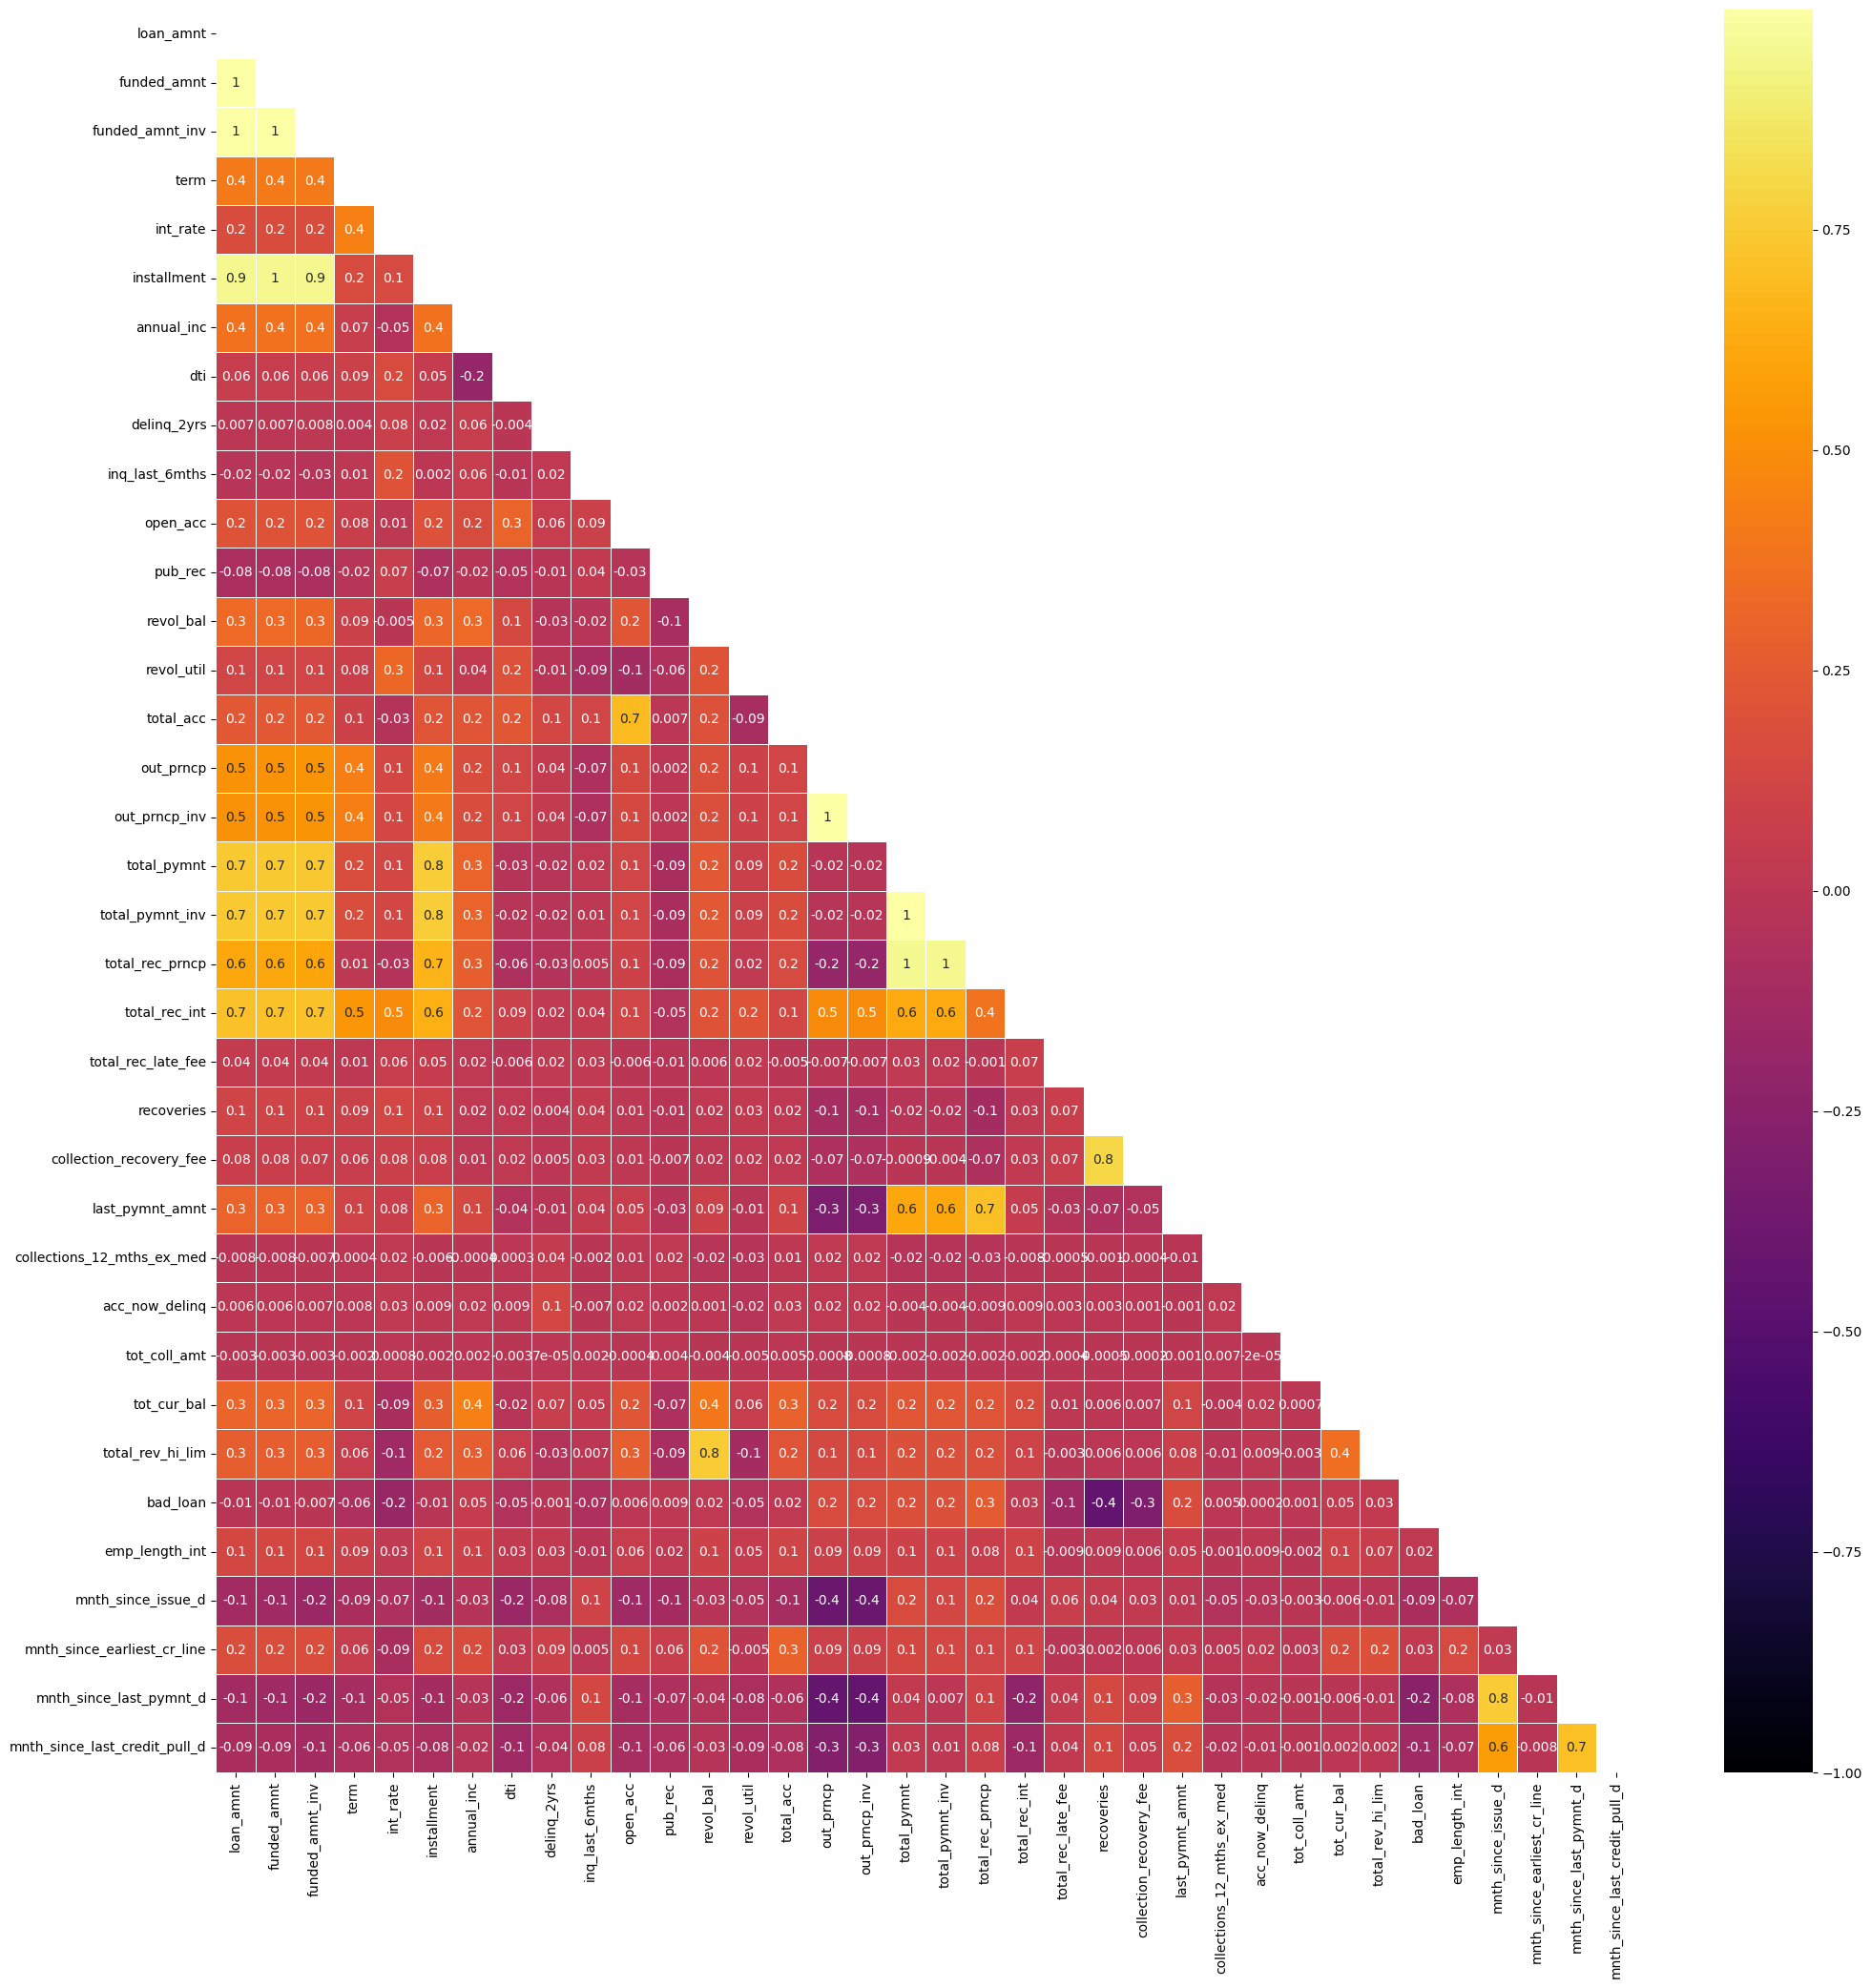

In [30]:
# Use only numeric columns for correlation
corr = df.select_dtypes(include=[np.number]).corr().fillna(0)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(24,24))
sns.heatmap(corr, mask=mask, annot=True, cmap="inferno", vmin=-1, fmt='.1g', edgecolor='w', linewidth=0.6)

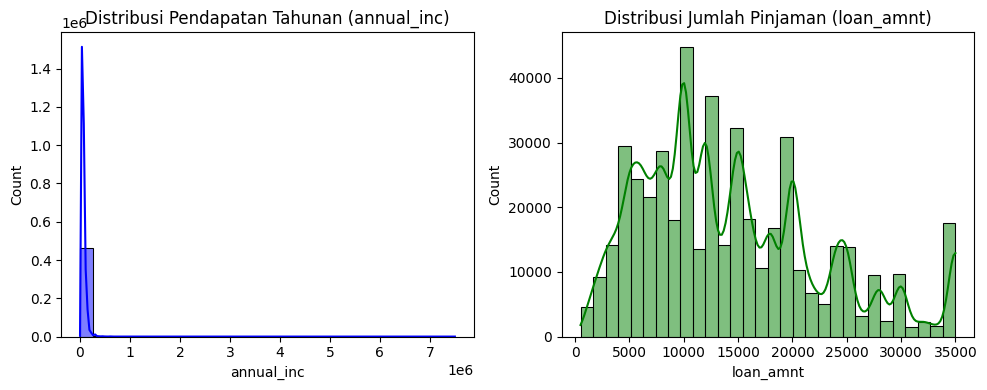

In [31]:
# Distribusi annual_inc
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['annual_inc'], bins=30, kde=True, color='blue')
plt.title('Distribusi Pendapatan Tahunan (annual_inc)')

# Distribusi loan_amnt
plt.subplot(1, 2, 2)
sns.histplot(df['loan_amnt'], bins=30, kde=True, color='green')
plt.title('Distribusi Jumlah Pinjaman (loan_amnt)')
plt.tight_layout()
plt.show()

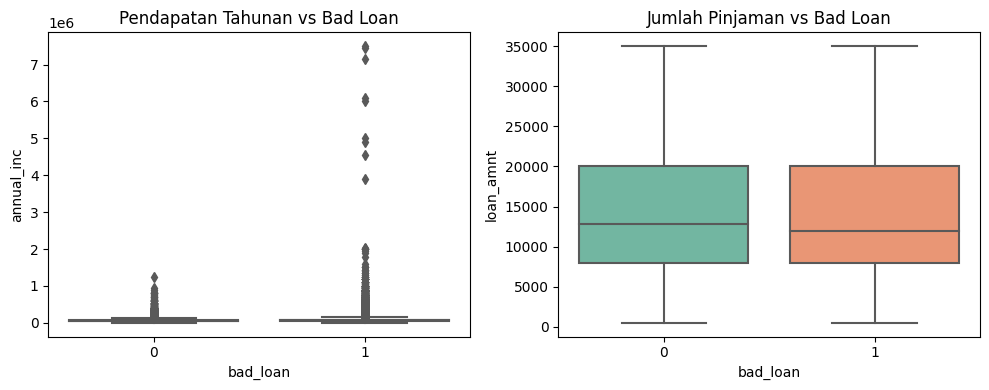

In [32]:
# Boxplot untuk annual_inc
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='bad_loan', y='annual_inc', data=df, palette='Set2')
plt.title('Pendapatan Tahunan vs Bad Loan')

# Boxplot untuk loan_amnt
plt.subplot(1, 2, 2)
sns.boxplot(x='bad_loan', y='loan_amnt', data=df, palette='Set2')
plt.title('Jumlah Pinjaman vs Bad Loan')
plt.tight_layout()
plt.show()

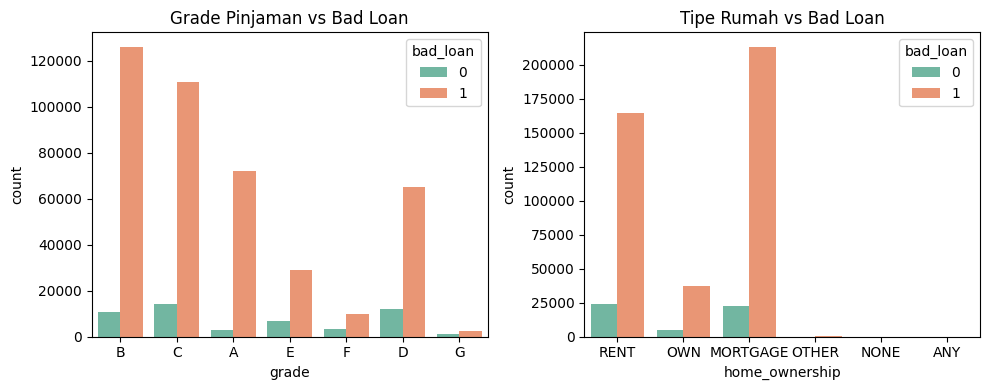

In [33]:
# Contoh: Grade
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='grade', hue='bad_loan', data=df, palette='Set2')
plt.title('Grade Pinjaman vs Bad Loan')

# Contoh: Home Ownership
plt.subplot(1, 2, 2)
sns.countplot(x='home_ownership', hue='bad_loan', data=df, palette='Set2')
plt.title('Tipe Rumah vs Bad Loan')
plt.tight_layout()
plt.show()

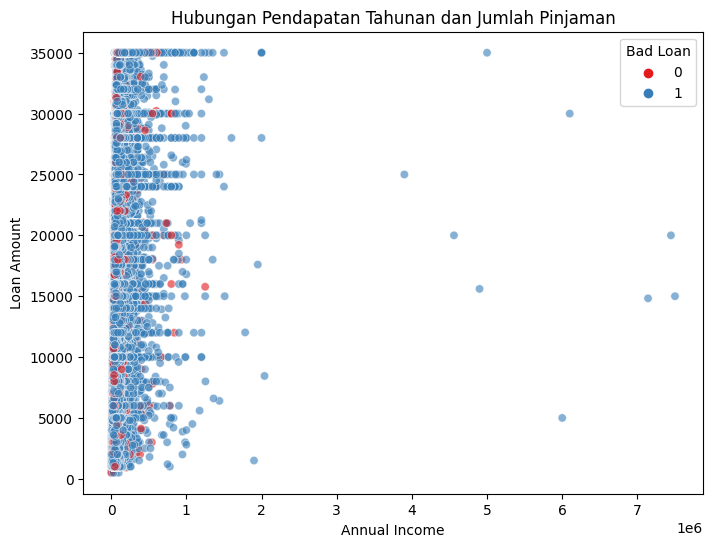

In [34]:
# Scatter plot antara loan_amnt dan annual_inc
plt.figure(figsize=(8, 6))
sns.scatterplot(x='annual_inc', y='loan_amnt', hue='bad_loan', data=df, alpha=0.6, palette='Set1')
plt.title('Hubungan Pendapatan Tahunan dan Jumlah Pinjaman')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.legend(title='Bad Loan')
plt.show()

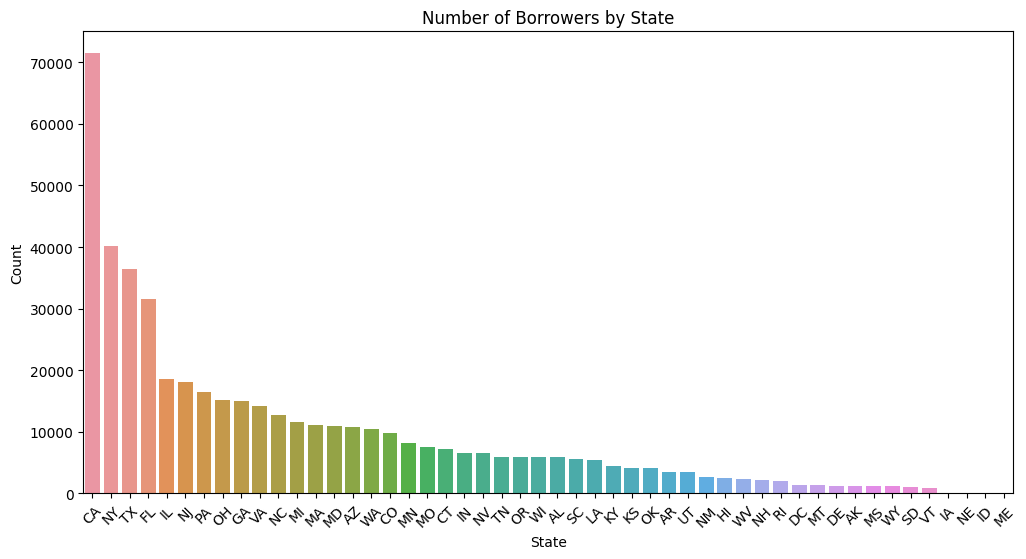

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='addr_state', order=df['addr_state'].value_counts().index)
plt.title('Number of Borrowers by State')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

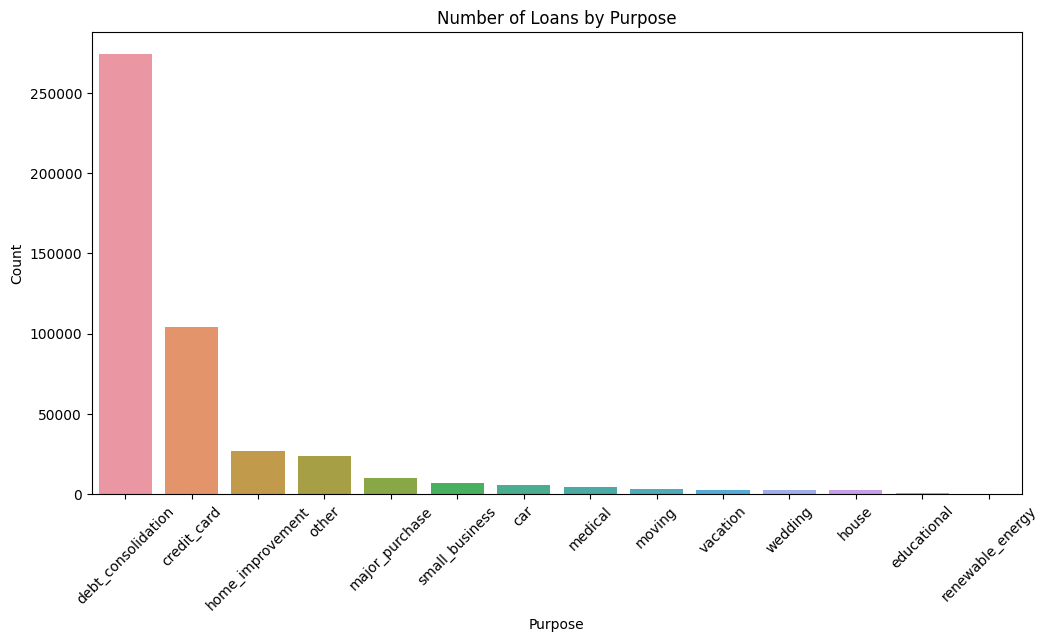

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='purpose', order=df['purpose'].value_counts().index)
plt.title('Number of Loans by Purpose')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [37]:
numerical_features.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,466285.0,14317.277577,8286.509164,500.00,8000.000000,12000.000000,20000.00000,3.500000e+04
funded_amnt,466285.0,14291.801044,8274.371300,500.00,8000.000000,12000.000000,20000.00000,3.500000e+04
funded_amnt_inv,466285.0,14222.329888,8297.637788,0.00,8000.000000,12000.000000,19950.00000,3.500000e+04
term,466285.0,42.605334,10.719040,36.00,36.000000,36.000000,60.00000,6.000000e+01
int_rate,466285.0,13.829236,4.357587,5.42,10.990000,13.660000,16.49000,2.606000e+01
installment,466285.0,432.061201,243.485550,15.67,256.690000,379.890000,566.58000,1.409990e+03
annual_inc,466281.0,73277.381470,54963.568654,1896.00,45000.000000,63000.000000,88960.00000,7.500000e+06
dti,466285.0,17.218758,7.851121,0.00,11.360000,16.870000,22.78000,3.999000e+01
delinq_2yrs,466256.0,0.284678,0.797365,0.00,0.000000,0.000000,0.00000,2.900000e+01
inq_last_6mths,466256.0,0.804745,1.091598,0.00,0.000000,0.000000,1.00000,3.300000e+01


Weight of Evidence (WoE) & Information Value (IV)

---

In [38]:
def iv_woe(df, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = df.columns
    
    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (df[ivars].dtype.kind in 'bifc') and (len(np.unique(df[ivars]))>10):
            binned_x = pd.qcut(df[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': df[target]})
        else:
            d0 = pd.DataFrame({'x': df[ivars], 'y': df[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(preprocess_data, target='bad_loan', bins=20)

Information value of loan_amnt is 0.004021
Information value of funded_amnt is 0.005335
Information value of funded_amnt_inv is 0.008519
Information value of term is 0.03886
Information value of int_rate is 0.330892
Information value of installment is 0.00716
Information value of grade is 0.290782
Information value of home_ownership is 0.021672
Information value of annual_inc is 0.055095
Information value of verification_status is 0.020831
Information value of purpose is 0.03698
Information value of addr_state is 0.012518
Information value of dti is 0.026295
Information value of delinq_2yrs is 4.5e-05
Information value of inq_last_6mths is 0.036969
Information value of open_acc is 0.000743
Information value of pub_rec is 0.00058
Information value of revol_bal is 0.006575
Information value of revol_util is 0.027617
Information value of total_acc is 0.007425
Information value of initial_list_status is 0.024801
Information value of out_prncp is 0.76565
Information value of out_prncp_inv i

In [39]:
# variables with IV < 0.02 are not useful for prediction and 
# IV > 0.5 have a suspicious predictive power

# drop columns with low IV
drop4 = ['last_pymnt_amnt', 'revol_util', 'delinq_2yrs', 'open_acc', 'pub_rec',  
         'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt']

preprocess_data.drop(drop4, axis=1, inplace=True)

In [40]:
# dummy variables for cat cols
data_dummies = [pd.get_dummies(preprocess_data['grade'], prefix='grade', prefix_sep=':'),
                pd.get_dummies(preprocess_data['home_ownership'], prefix='home_ownership', prefix_sep=':'),
                pd.get_dummies(preprocess_data['verification_status'], prefix='verification_status', prefix_sep=':'),
                pd.get_dummies(preprocess_data['purpose'], prefix='purpose', prefix_sep=':'),
                pd.get_dummies(preprocess_data['addr_state'], prefix='addr_state', prefix_sep=':'),
                pd.get_dummies(preprocess_data['initial_list_status'], prefix='initial_list_status', prefix_sep=':')]

In [41]:
# turn  data_dummies into dataframe
categorical_dummies = pd.concat(data_dummies, axis=1)

In [42]:
# concatinating preprocess_data with categorical_dummies
preprocess_data = pd.concat([preprocess_data, categorical_dummies], axis=1)


In [43]:
# function to calculate WoE of cat features

def woe_categorical(df, cat_feature, good_bad_df):
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [44]:
# function to plot WoE
import numpy as np

def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 12))
    plt.plot(x, y, marker = 'o', color = 'hotpink', linestyle = 'dashed', linewidth = 3, markersize = 18, markeredgecolor = 'cyan', markerfacecolor = 'black')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels) 
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [45]:
# function to calculate WoE for continous variables
def woe_continous(df, cat_feature, good_bad_df):
    df = pd.concat([df[cat_feature], good_bad_df], axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [46]:
#seperating data into target and features
X = preprocess_data.drop(columns='bad_loan', axis=1)
y = preprocess_data['bad_loan']

categorical data

- grade

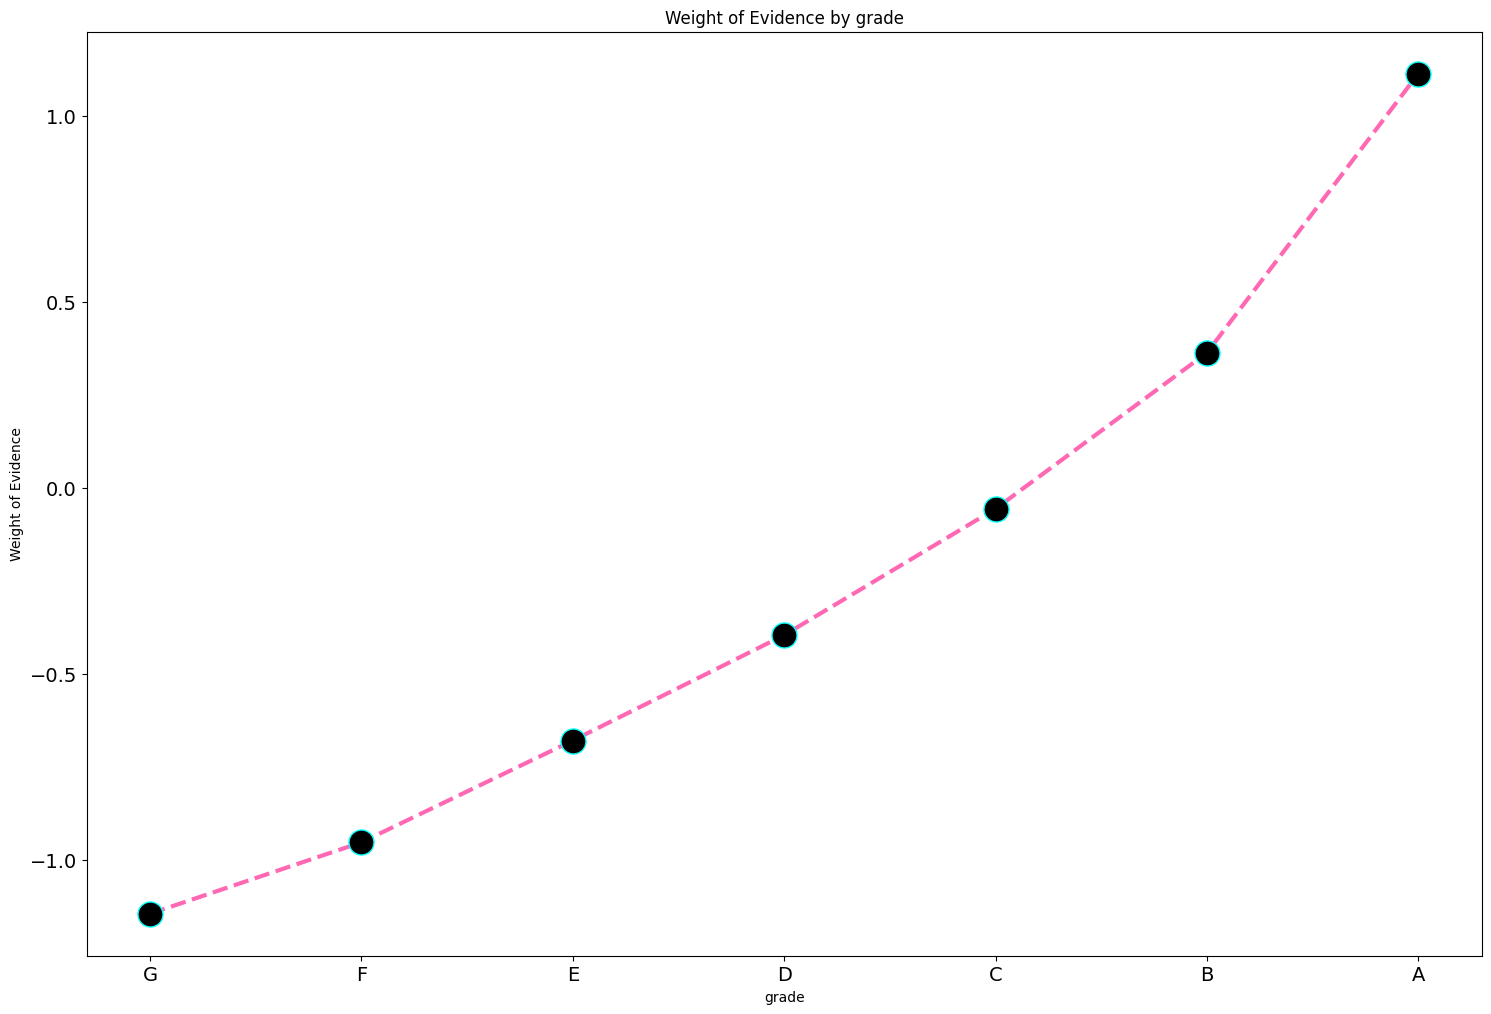

In [47]:
df_grade = woe_categorical(X, 'grade', y)
plot_by_woe(df_grade)

- home_ownership

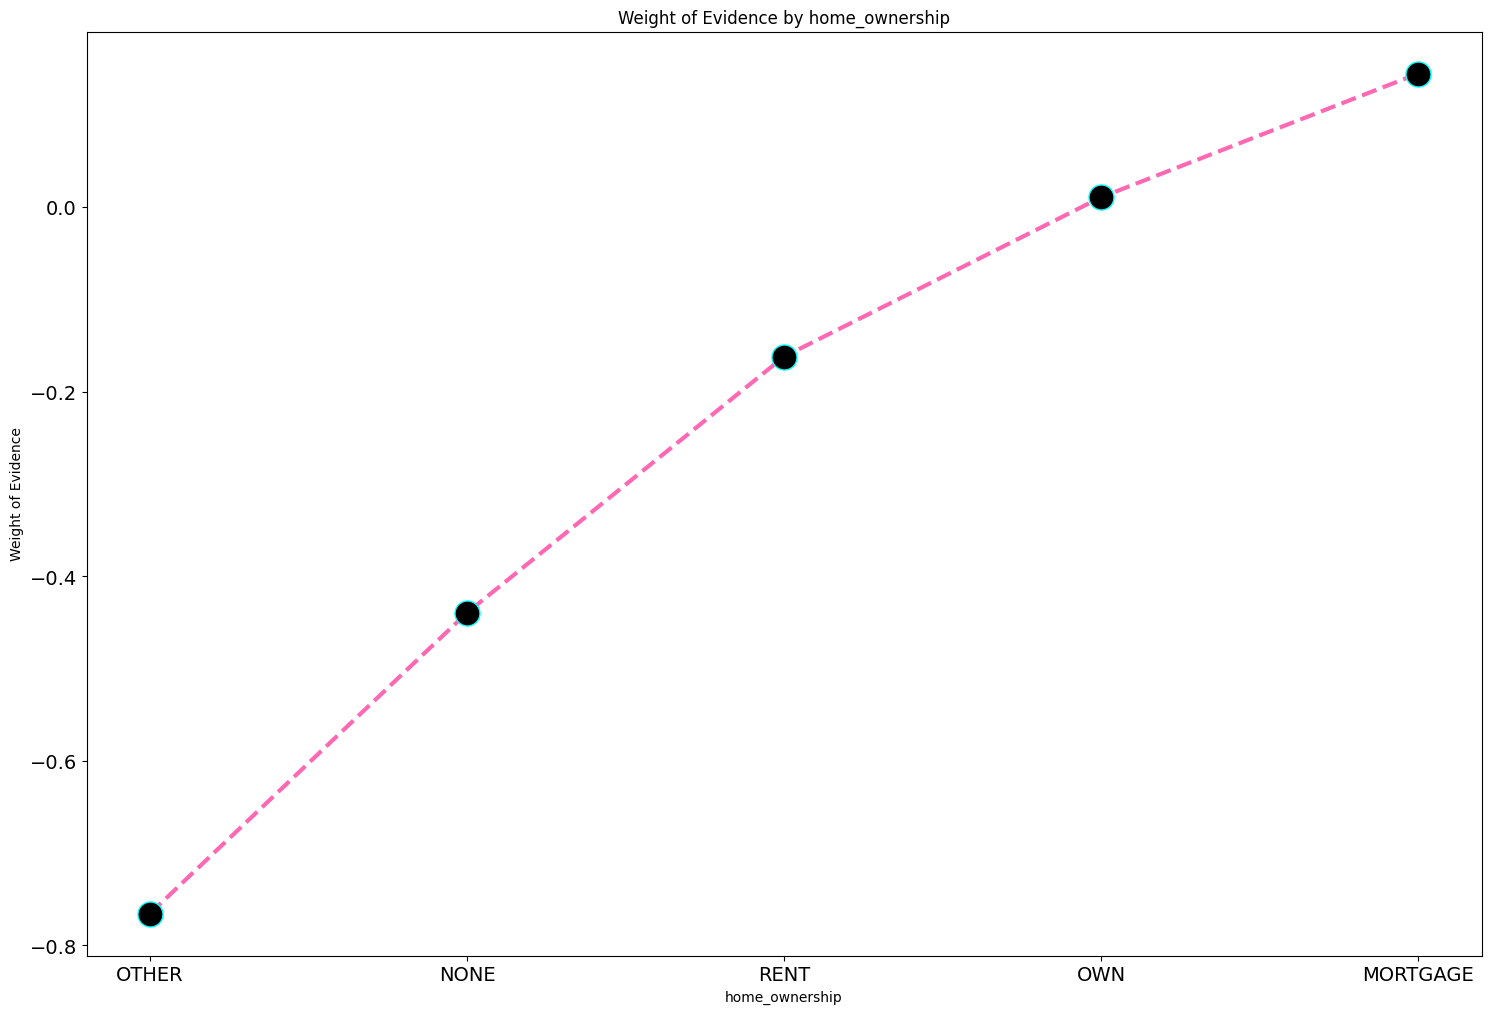

In [48]:
df_home = woe_categorical(X, 'home_ownership', y)
plot_by_woe(df_home)

- verification_status

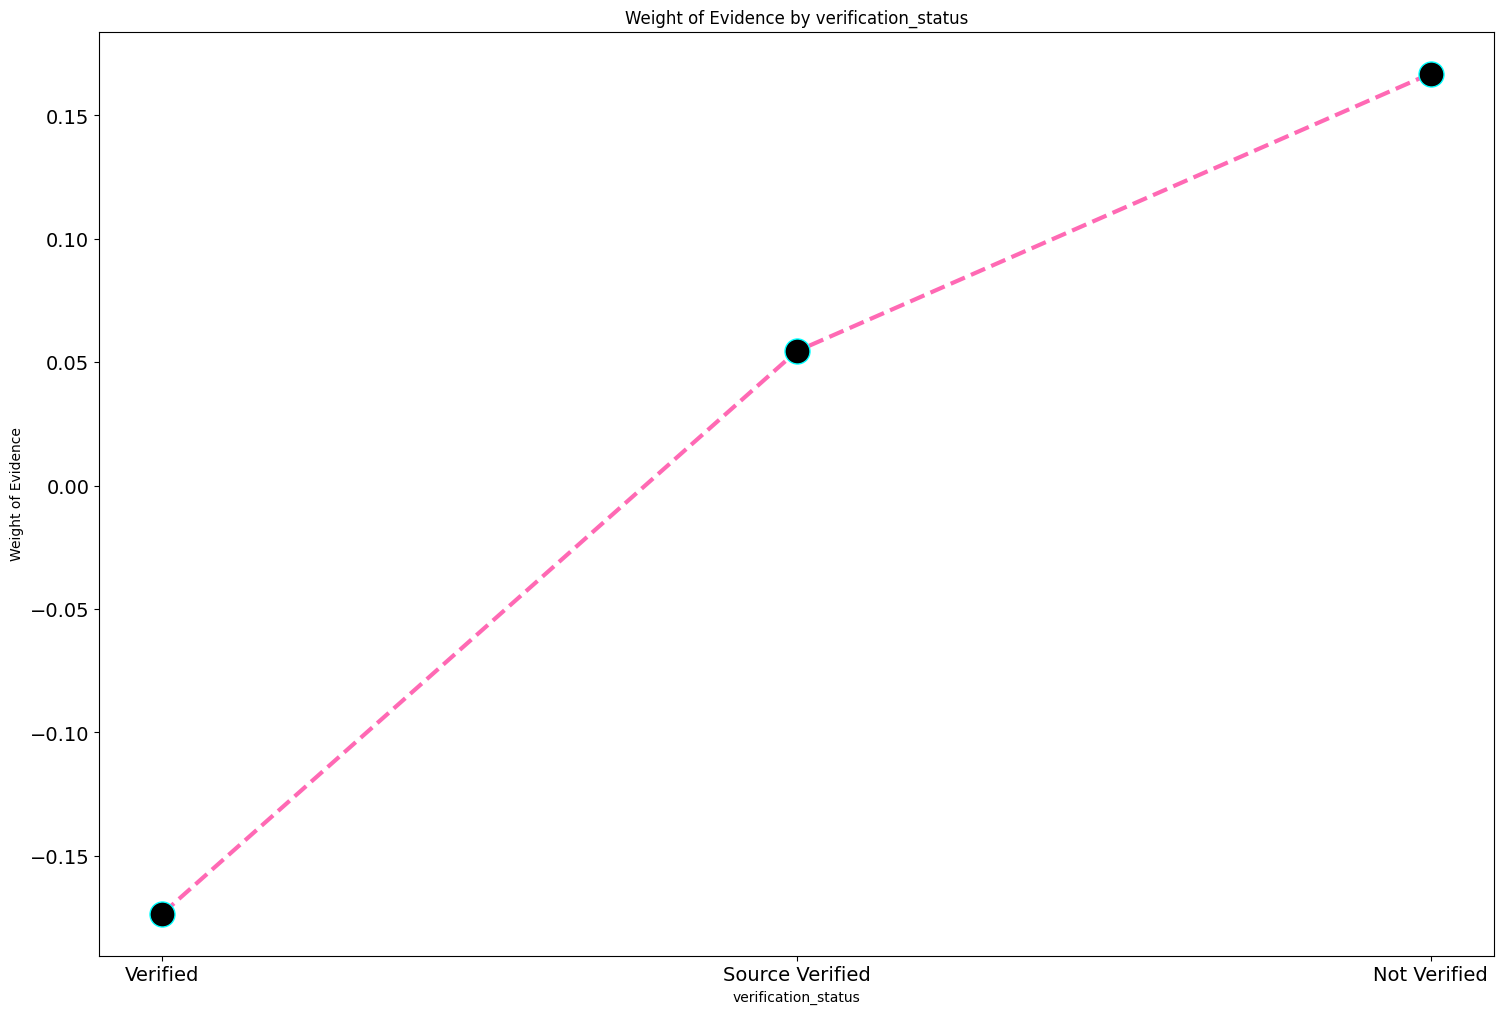

In [49]:
veri_df = woe_categorical(X, 'verification_status', y)
plot_by_woe(veri_df)

- purpose

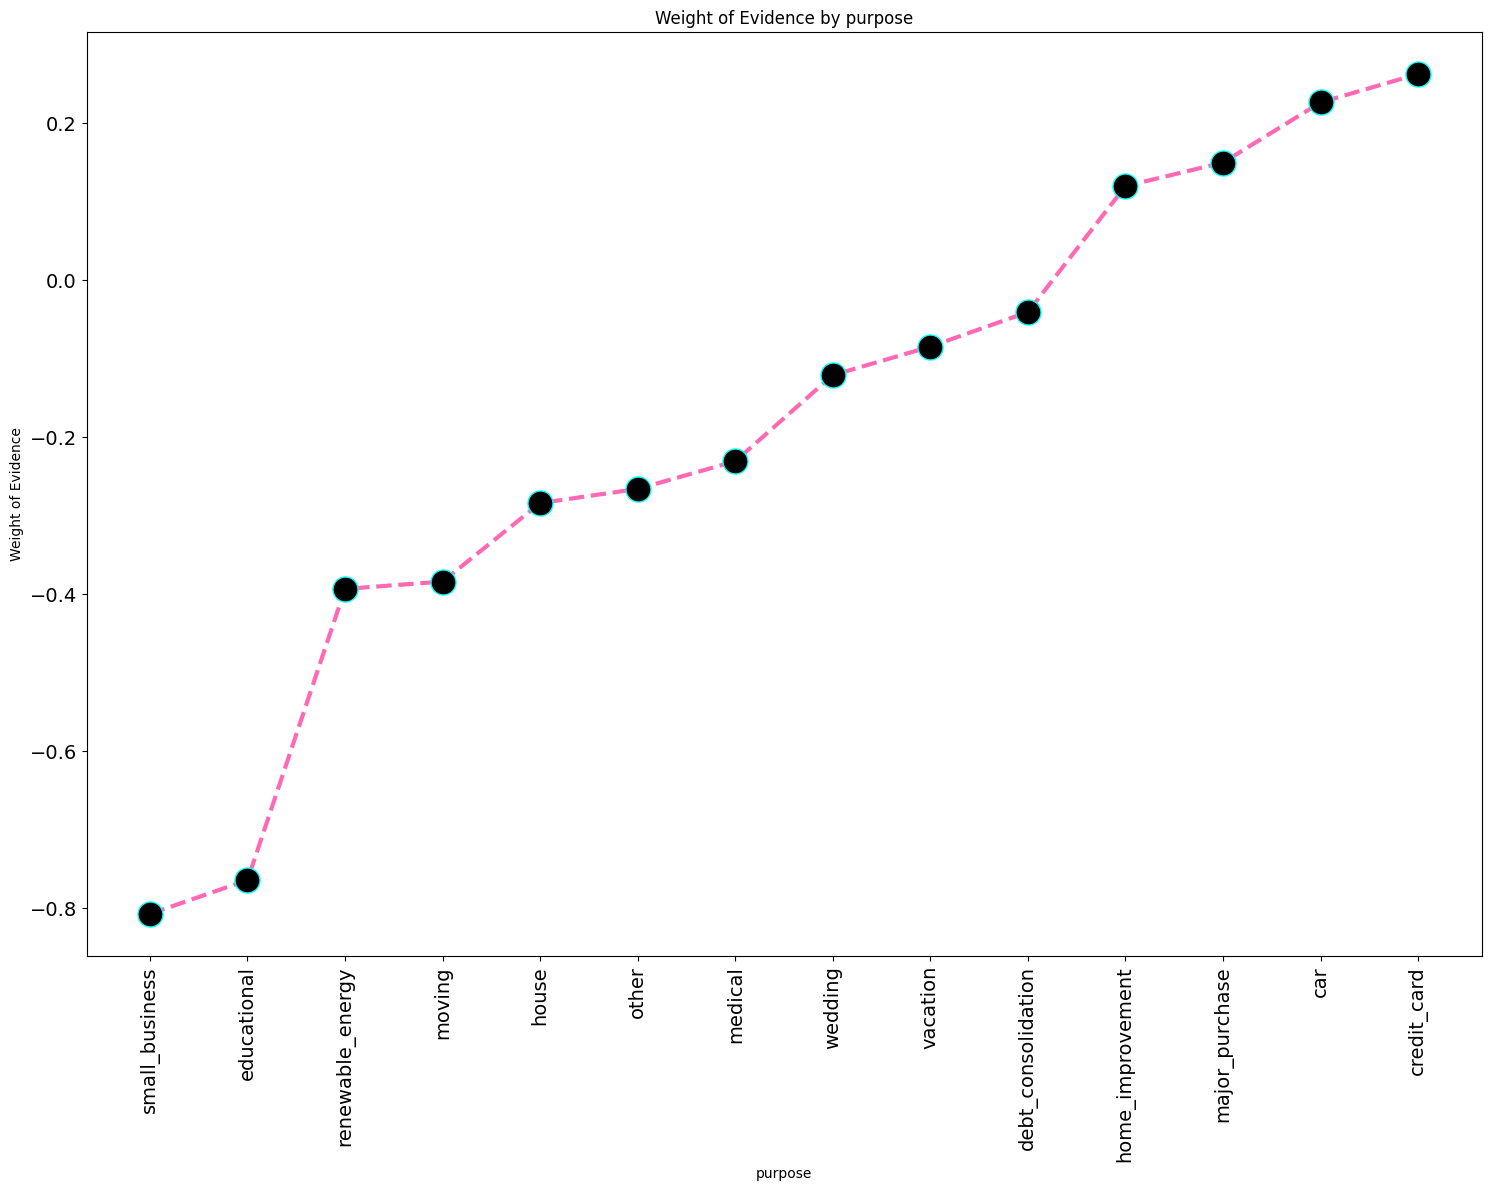

In [50]:
pur_df = woe_categorical(X, 'purpose', y)
plot_by_woe(pur_df, 90)

- addr_state

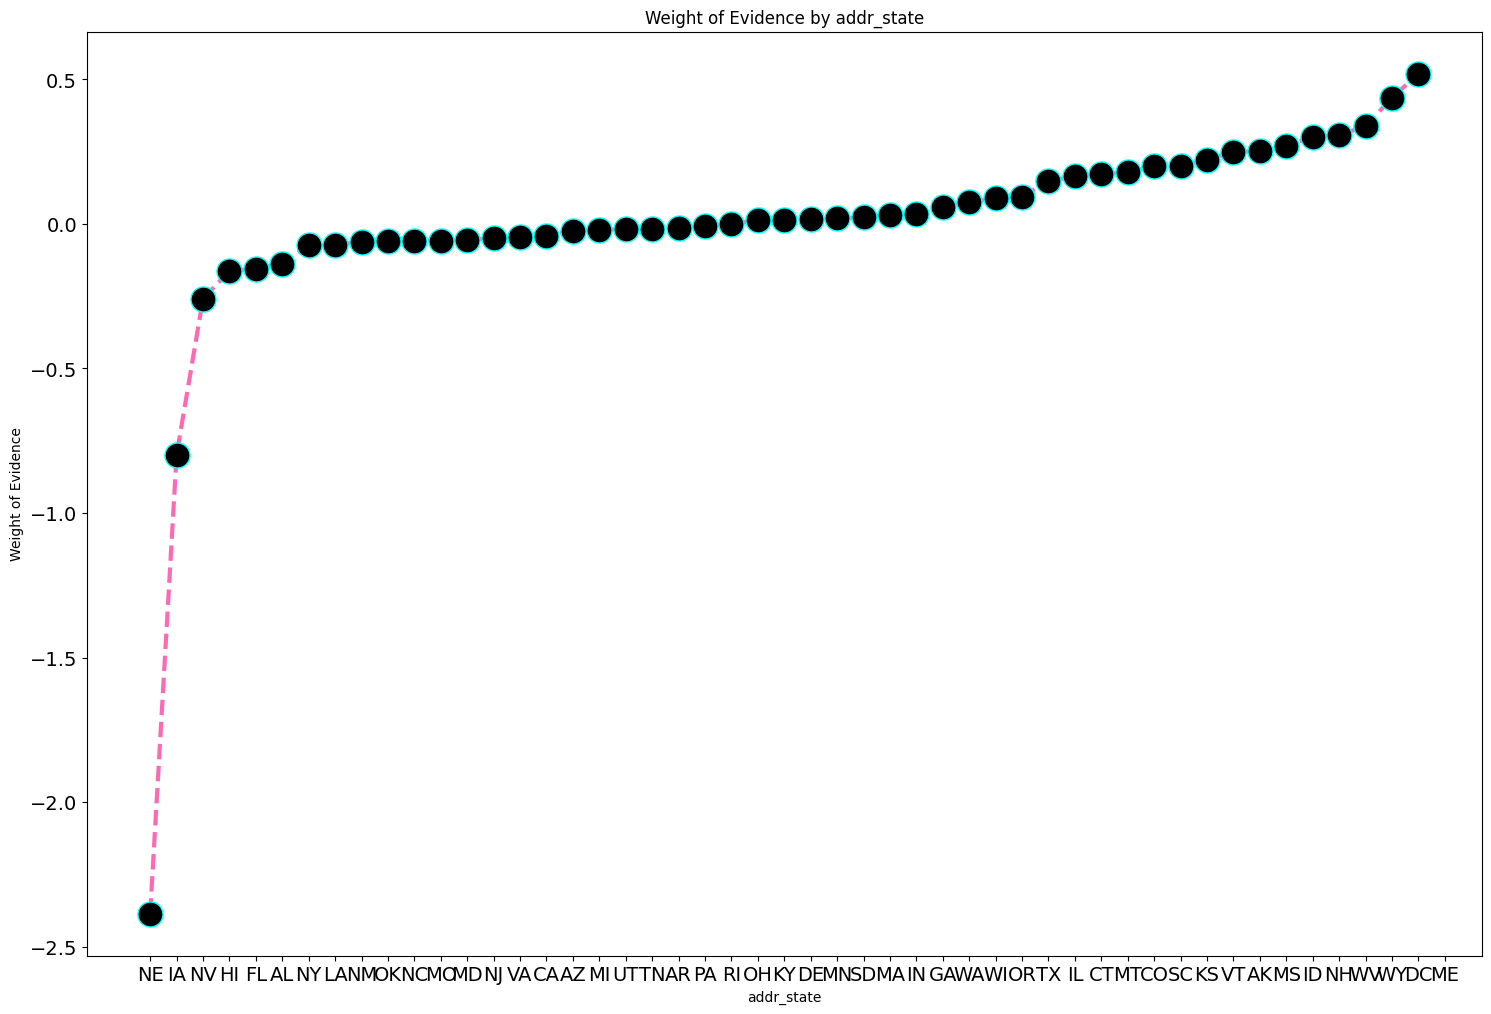

In [51]:
addr_df = woe_categorical(X, 'addr_state', y)
plot_by_woe(addr_df)

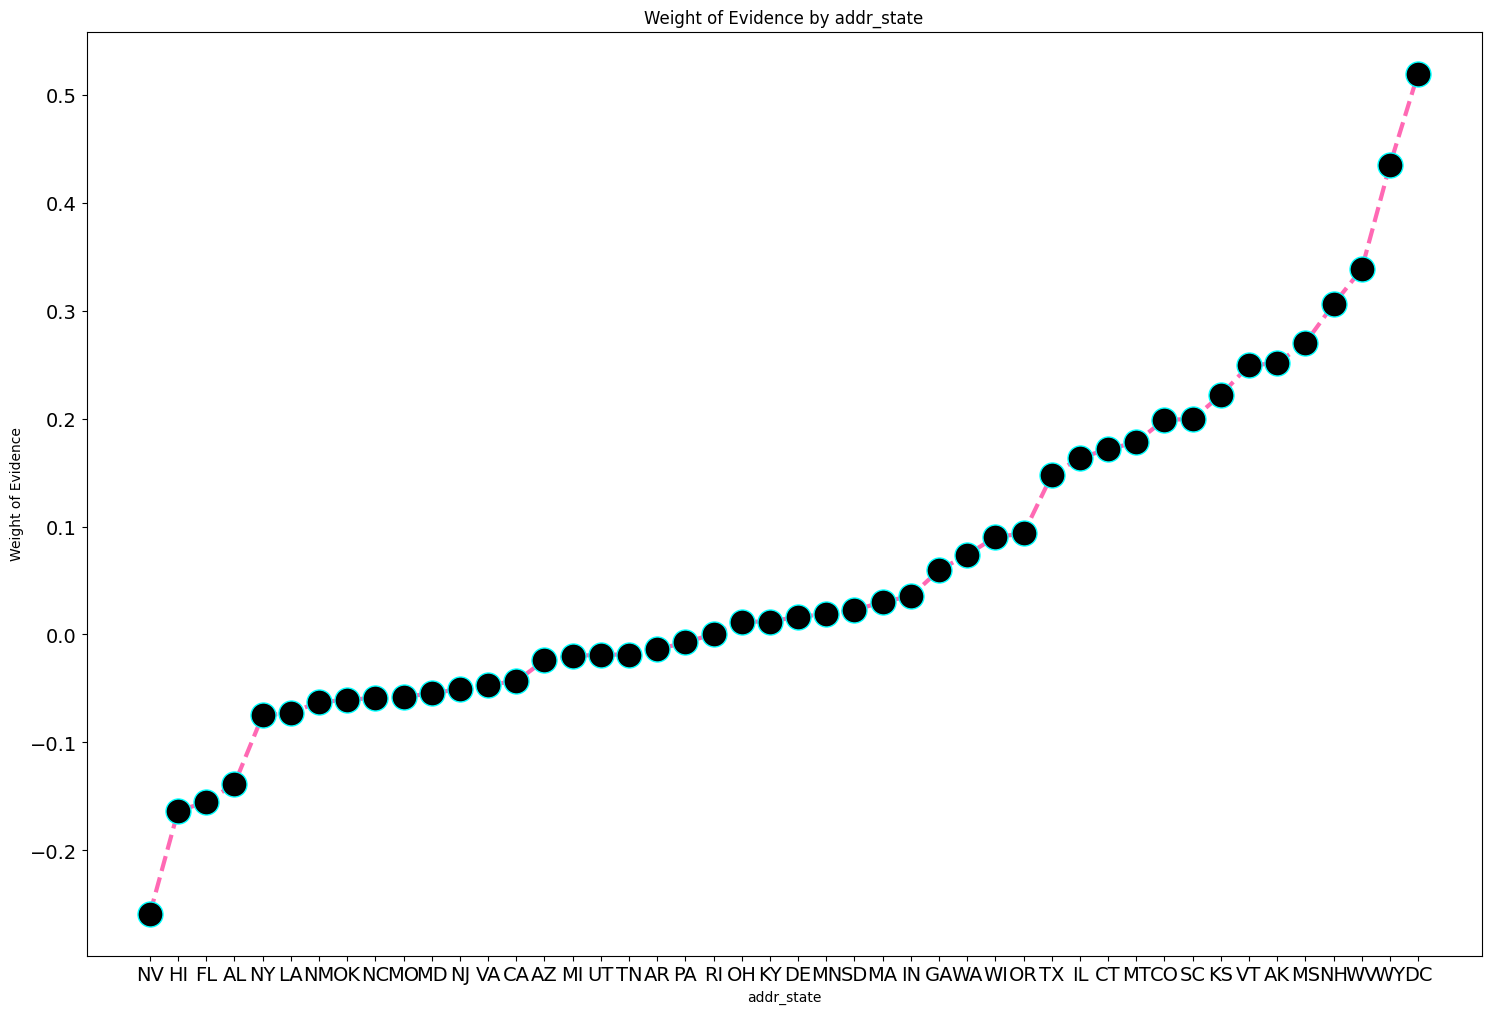

In [52]:
data1 = addr_df.iloc[2:44, :]
data2 = addr_df.iloc[45:49, :]
low_data_woe = pd.concat([data1, data2], axis=0)
plot_by_woe(low_data_woe)

- initial_list_status

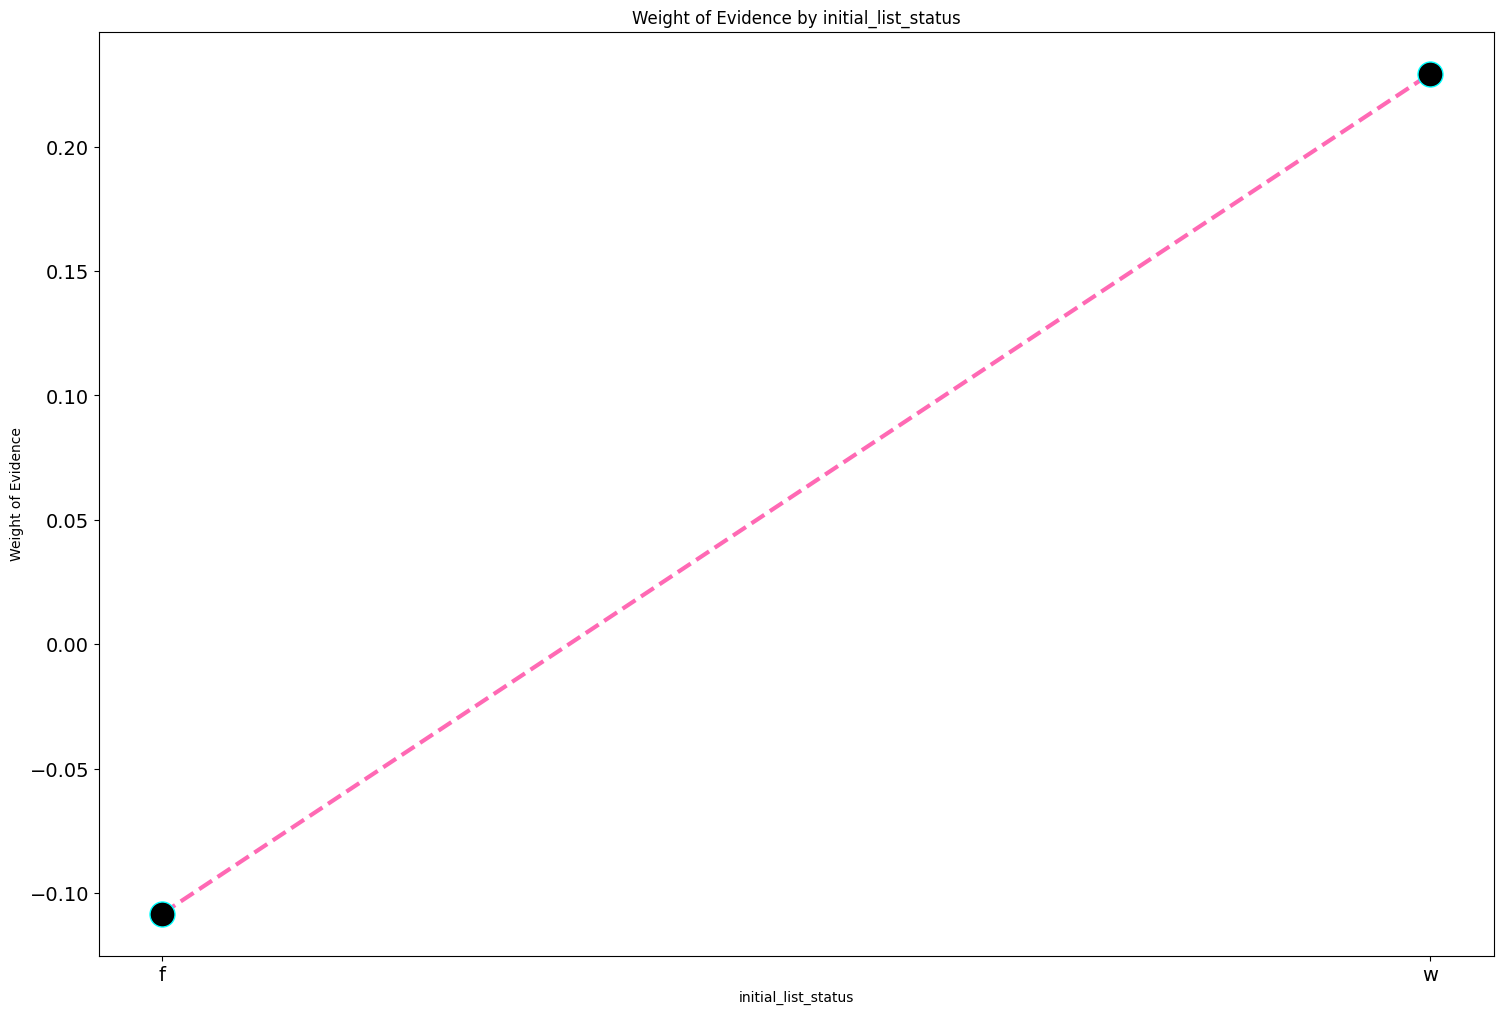

In [53]:
init_list_df = woe_categorical( X, 'initial_list_status', y)
plot_by_woe(init_list_df)

numerical data

- mnth_since_issue_d

In [54]:
X['mnth_since_issue_d'].unique()

array([ 72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
        94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       116., 117., 118., 119., 120., 121., 122., 123., 124., 125., 126.,
        48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
        70.,  71.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.])

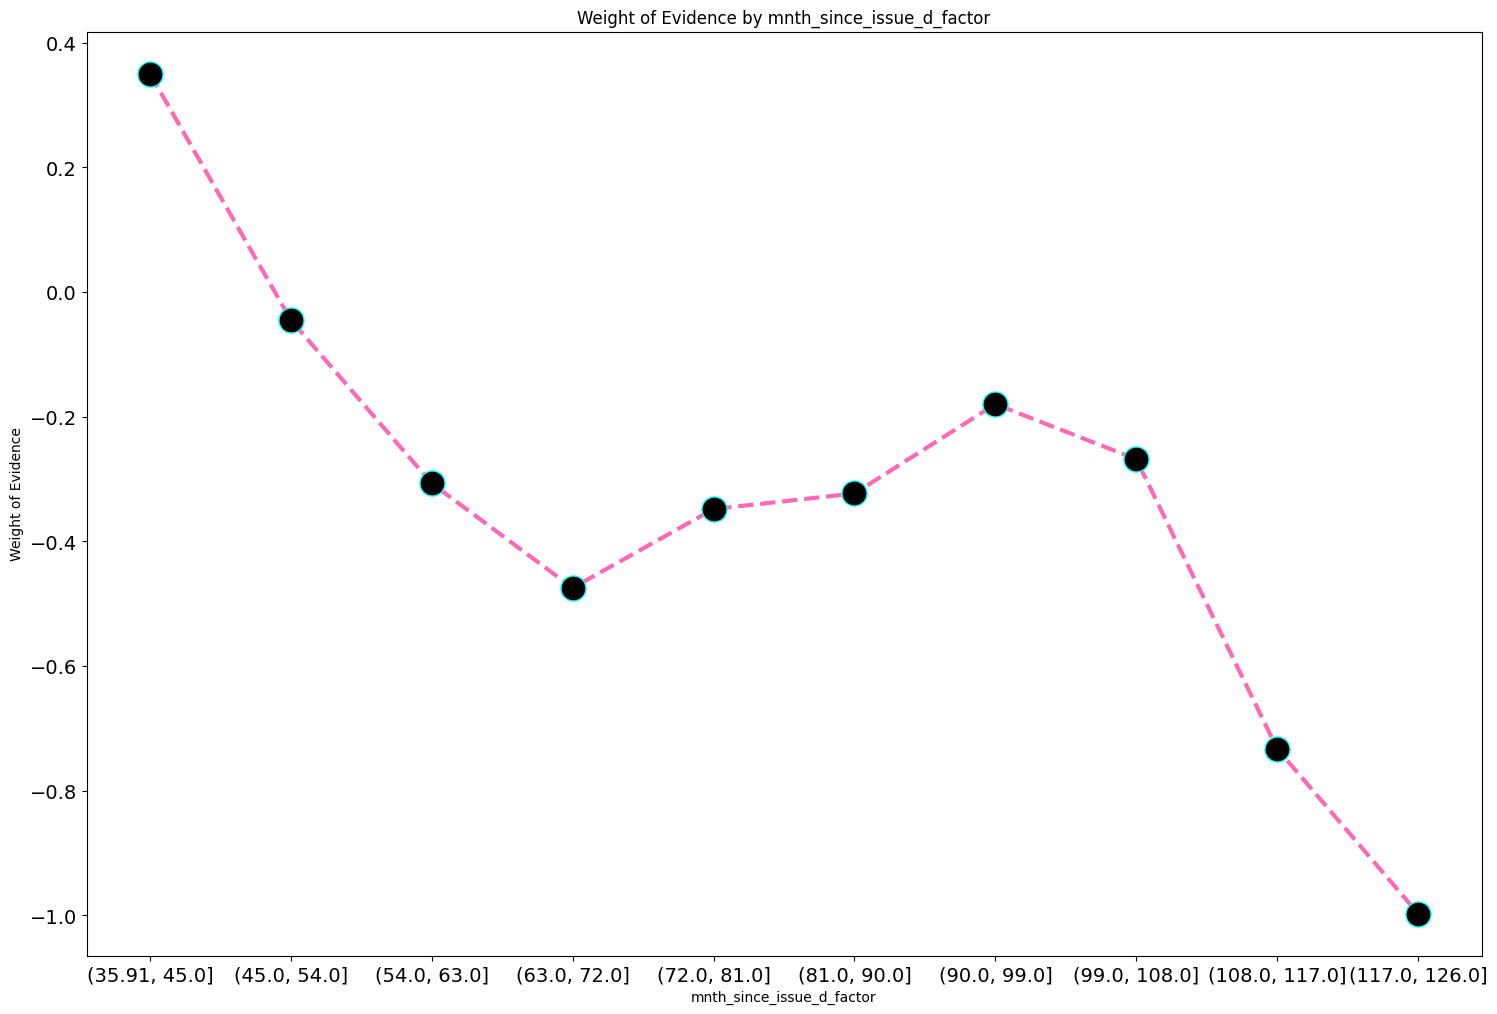

In [55]:
X['mnth_since_issue_d_factor'] = pd.cut(X['mnth_since_issue_d'], 10)
mths_since_iss_df = woe_continous(X, 'mnth_since_issue_d_factor', y)
plot_by_woe(mths_since_iss_df)

- interest rate

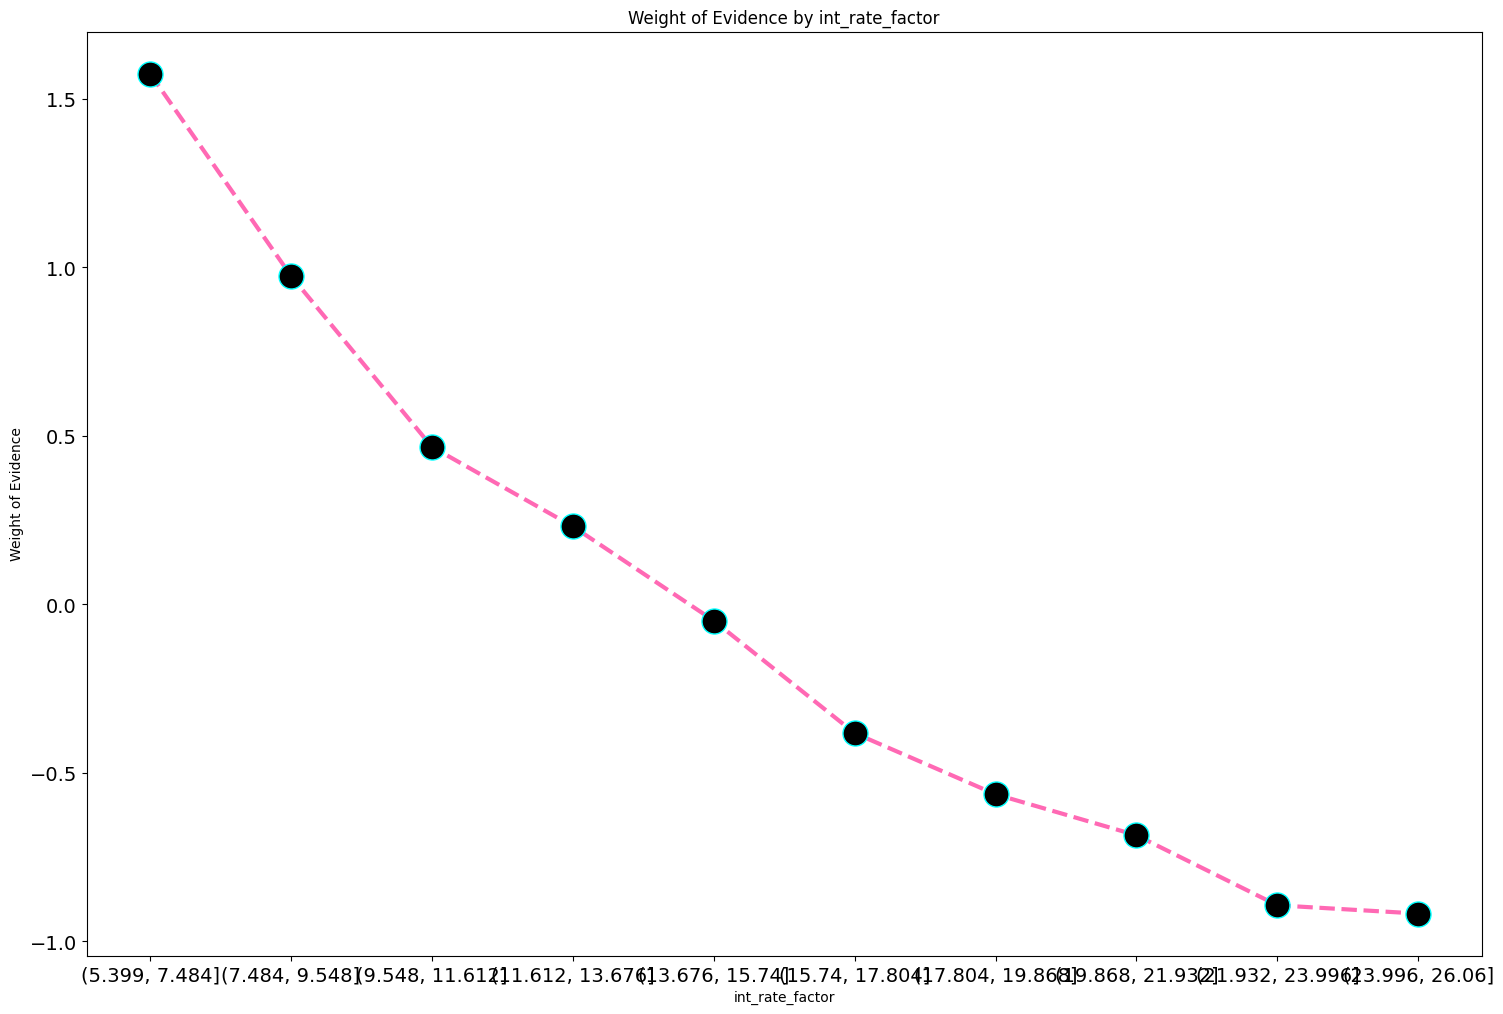

In [56]:
X['int_rate_factor'] = pd.cut(X['int_rate'], 10)
int_rate_df = woe_continous(X, 'int_rate_factor',y)
plot_by_woe(int_rate_df)

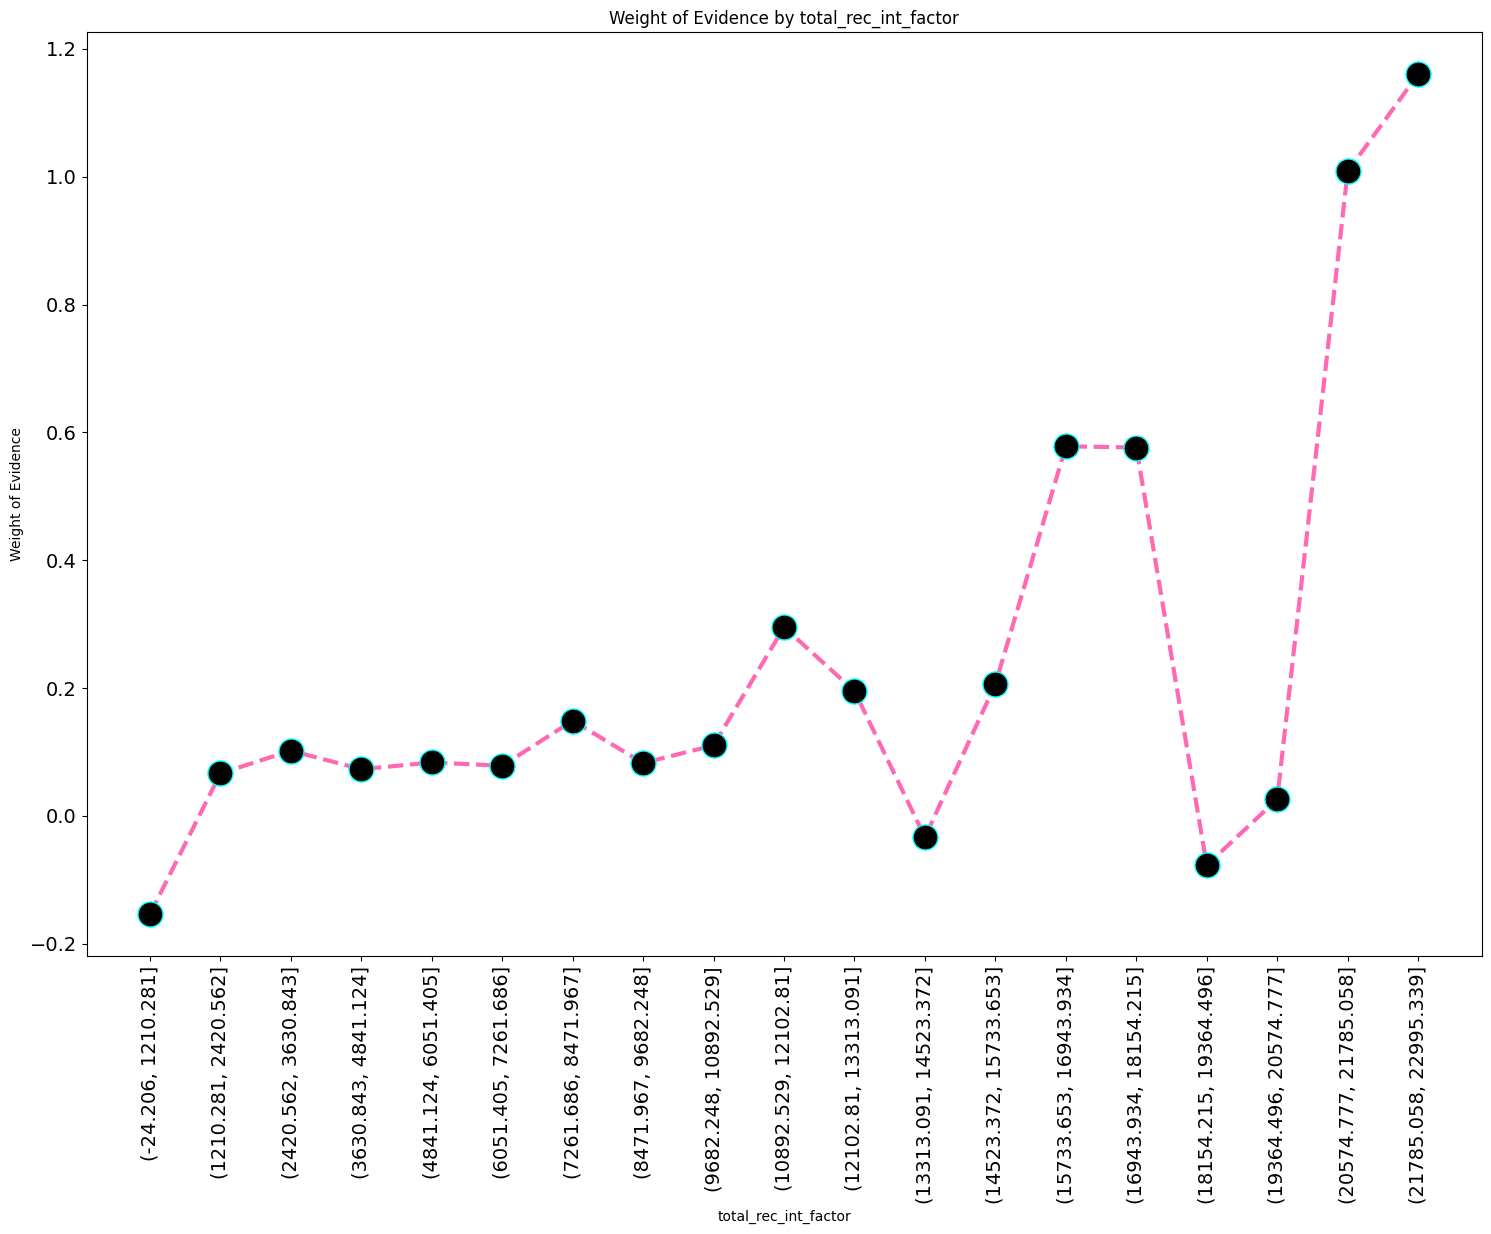

In [57]:
X['total_rec_int_factor'] = pd.cut(X['total_rec_int'], 20)
rec_int_df = woe_continous(X, 'total_rec_int_factor', y)
plot_by_woe(rec_int_df, 90)

- total_rev_hi_lim

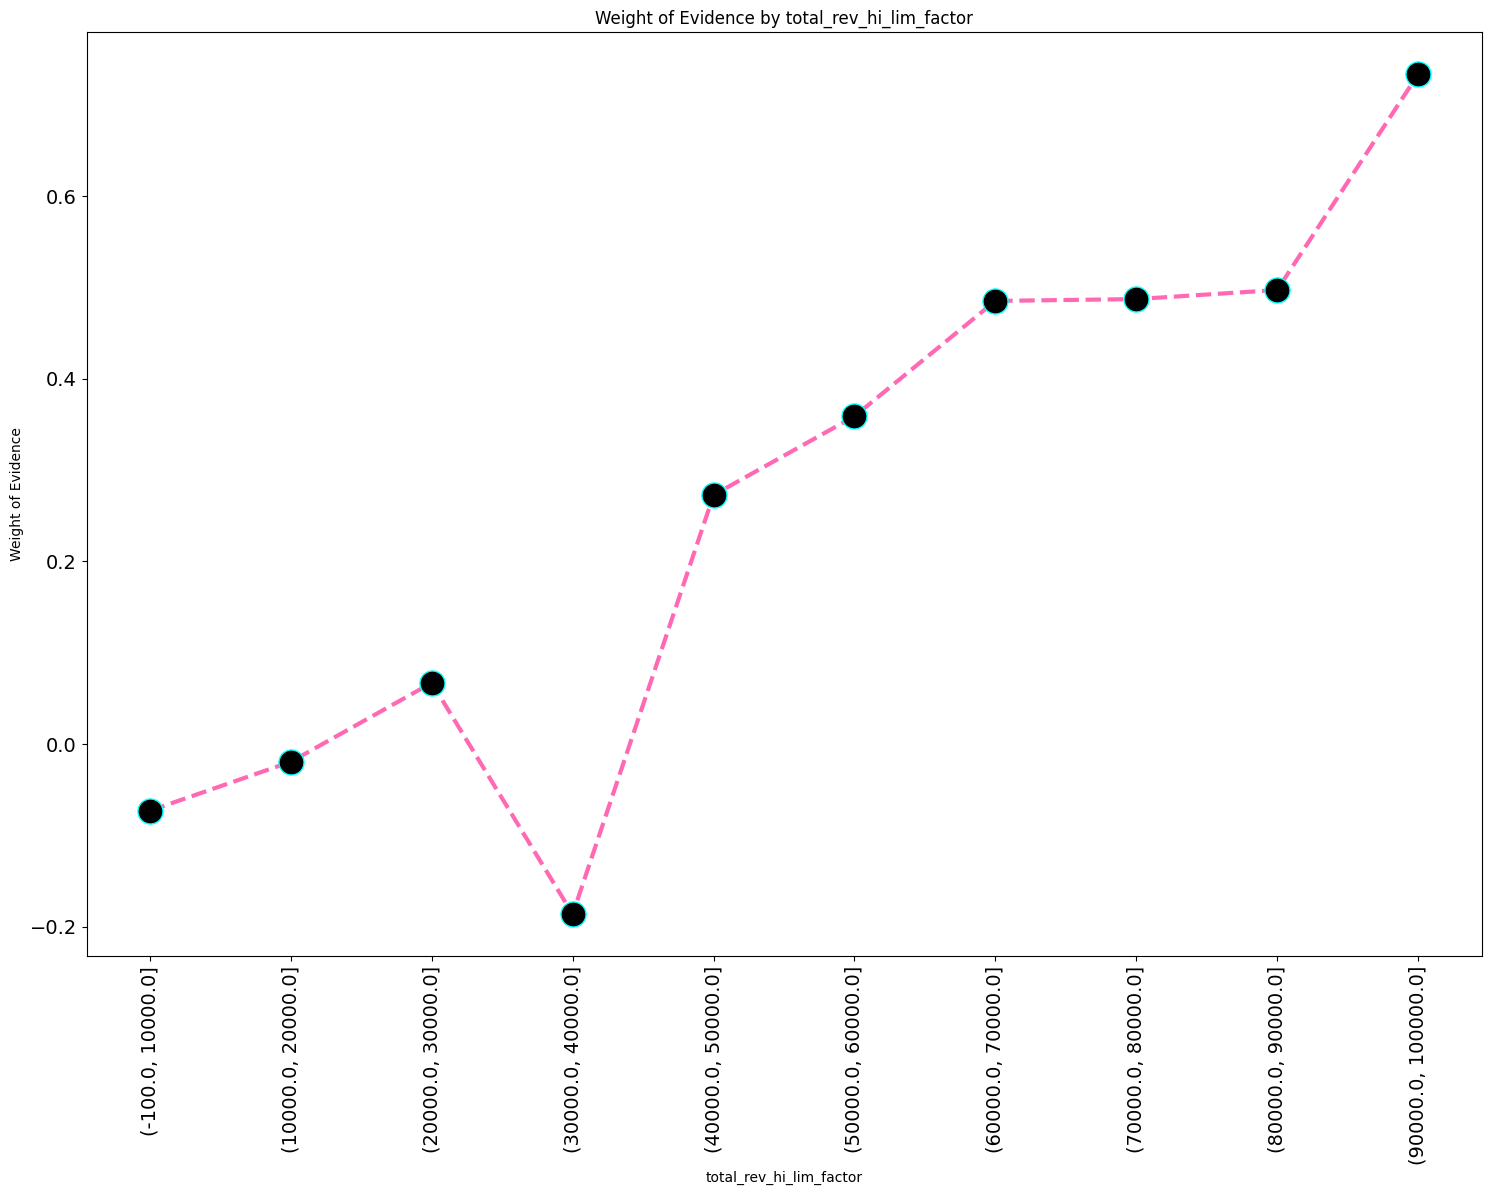

In [58]:
X['total_rev_hi_lim_factor'] = pd.cut(X['total_rev_hi_lim'], 100)
revol_hi_df = woe_continous(X, 'total_rev_hi_lim_factor', y)

#analyzing below 100000
X_train_prepr_temp = X[X['total_rev_hi_lim'] <= 100000].copy()
# fine-classing
X_train_prepr_temp['total_rev_hi_lim_factor'] = pd.cut(X_train_prepr_temp['total_rev_hi_lim'],10)
# select only the relevant index in the target col
df_temp = woe_continous(X_train_prepr_temp, 'total_rev_hi_lim_factor', y[X_train_prepr_temp.index])
plot_by_woe(df_temp, 90)

- total_pymnt

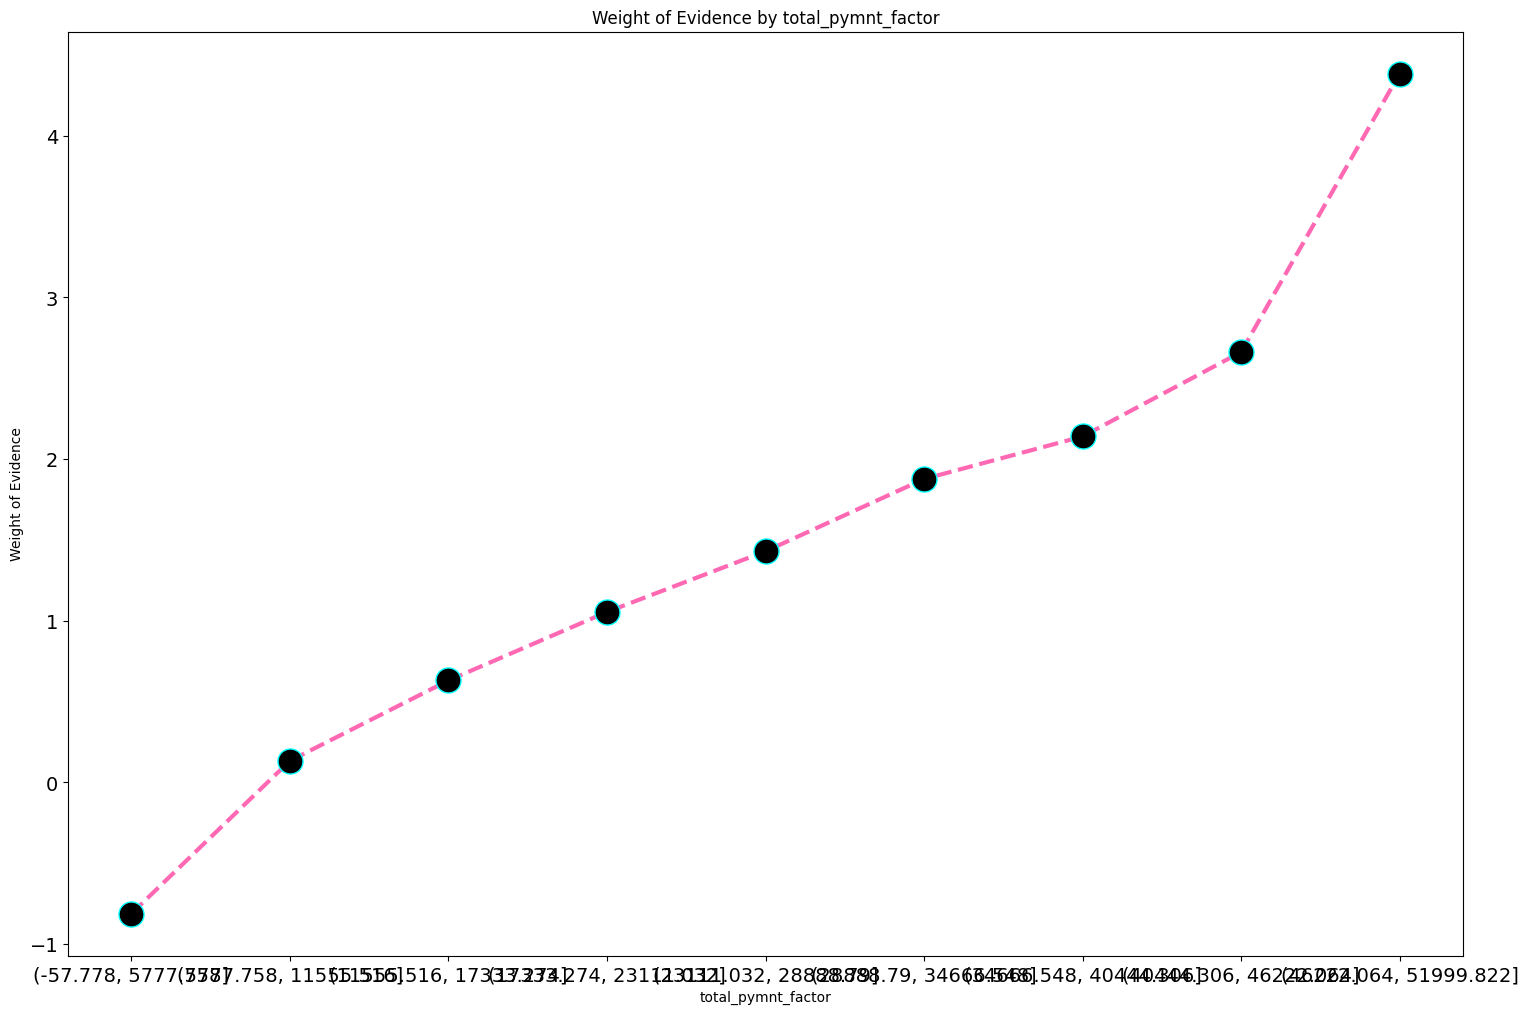

In [59]:
X['total_pymnt_factor'] = pd.cut(X['total_pymnt'], 10)
total_pym_df = woe_continous(X, 'total_pymnt_factor', y)
plot_by_woe(total_pym_df)

- dti

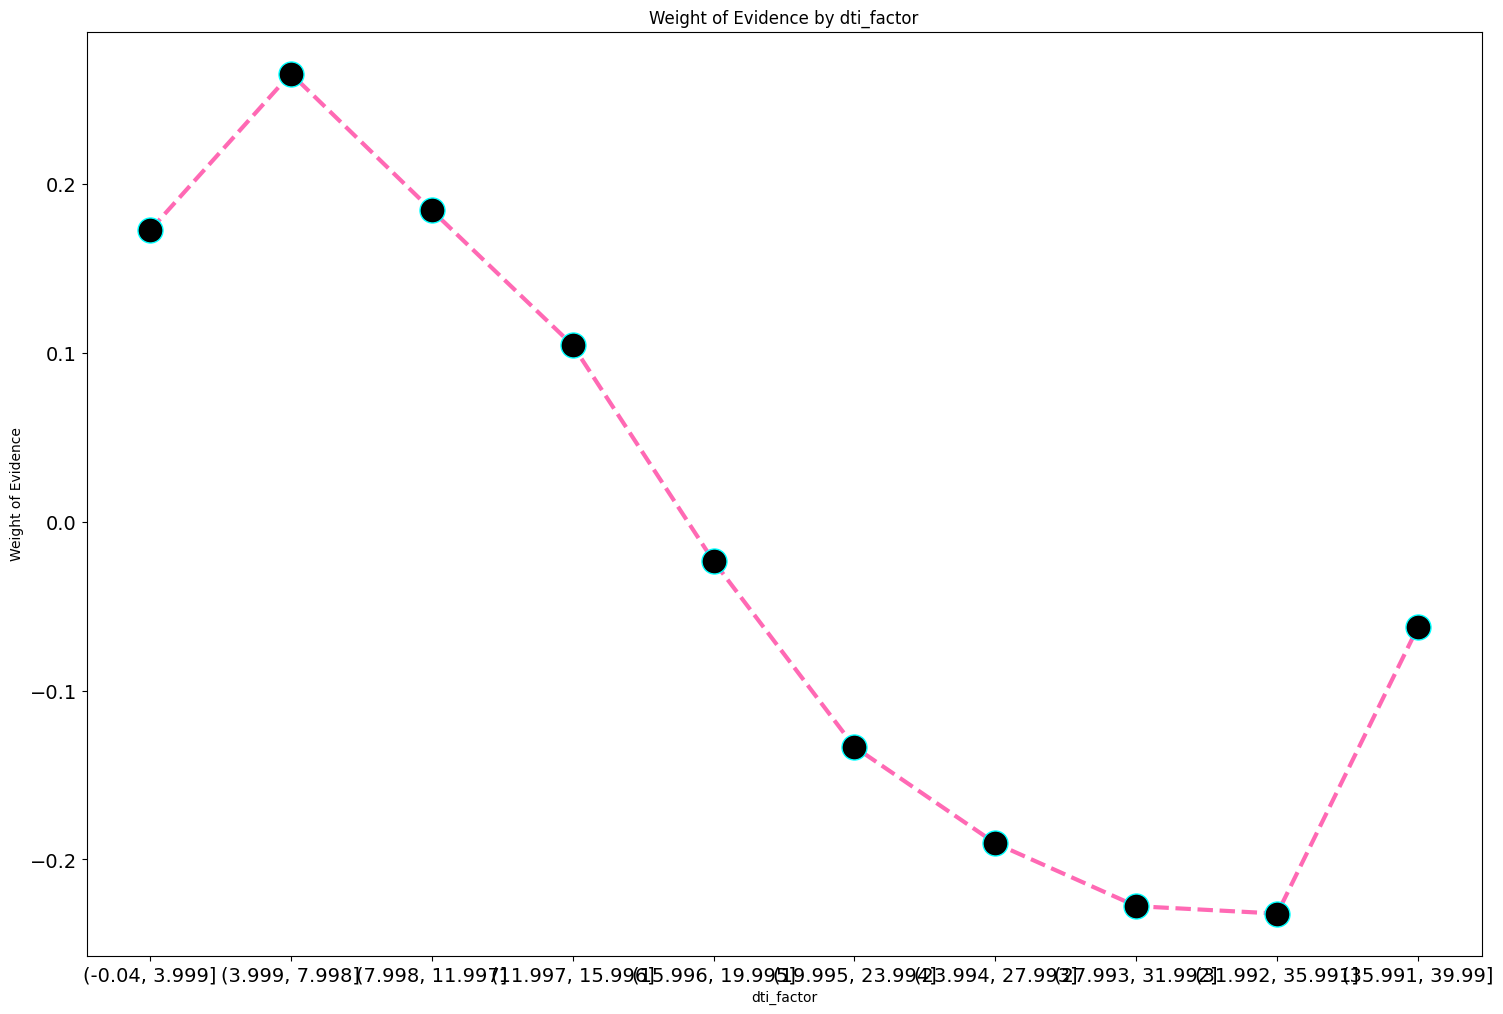

In [60]:
X['dti_factor'] = pd.cut(X['dti'], 10)
dti_df = woe_continous(X, 'dti_factor', y)
plot_by_woe(dti_df)

- annual_inc

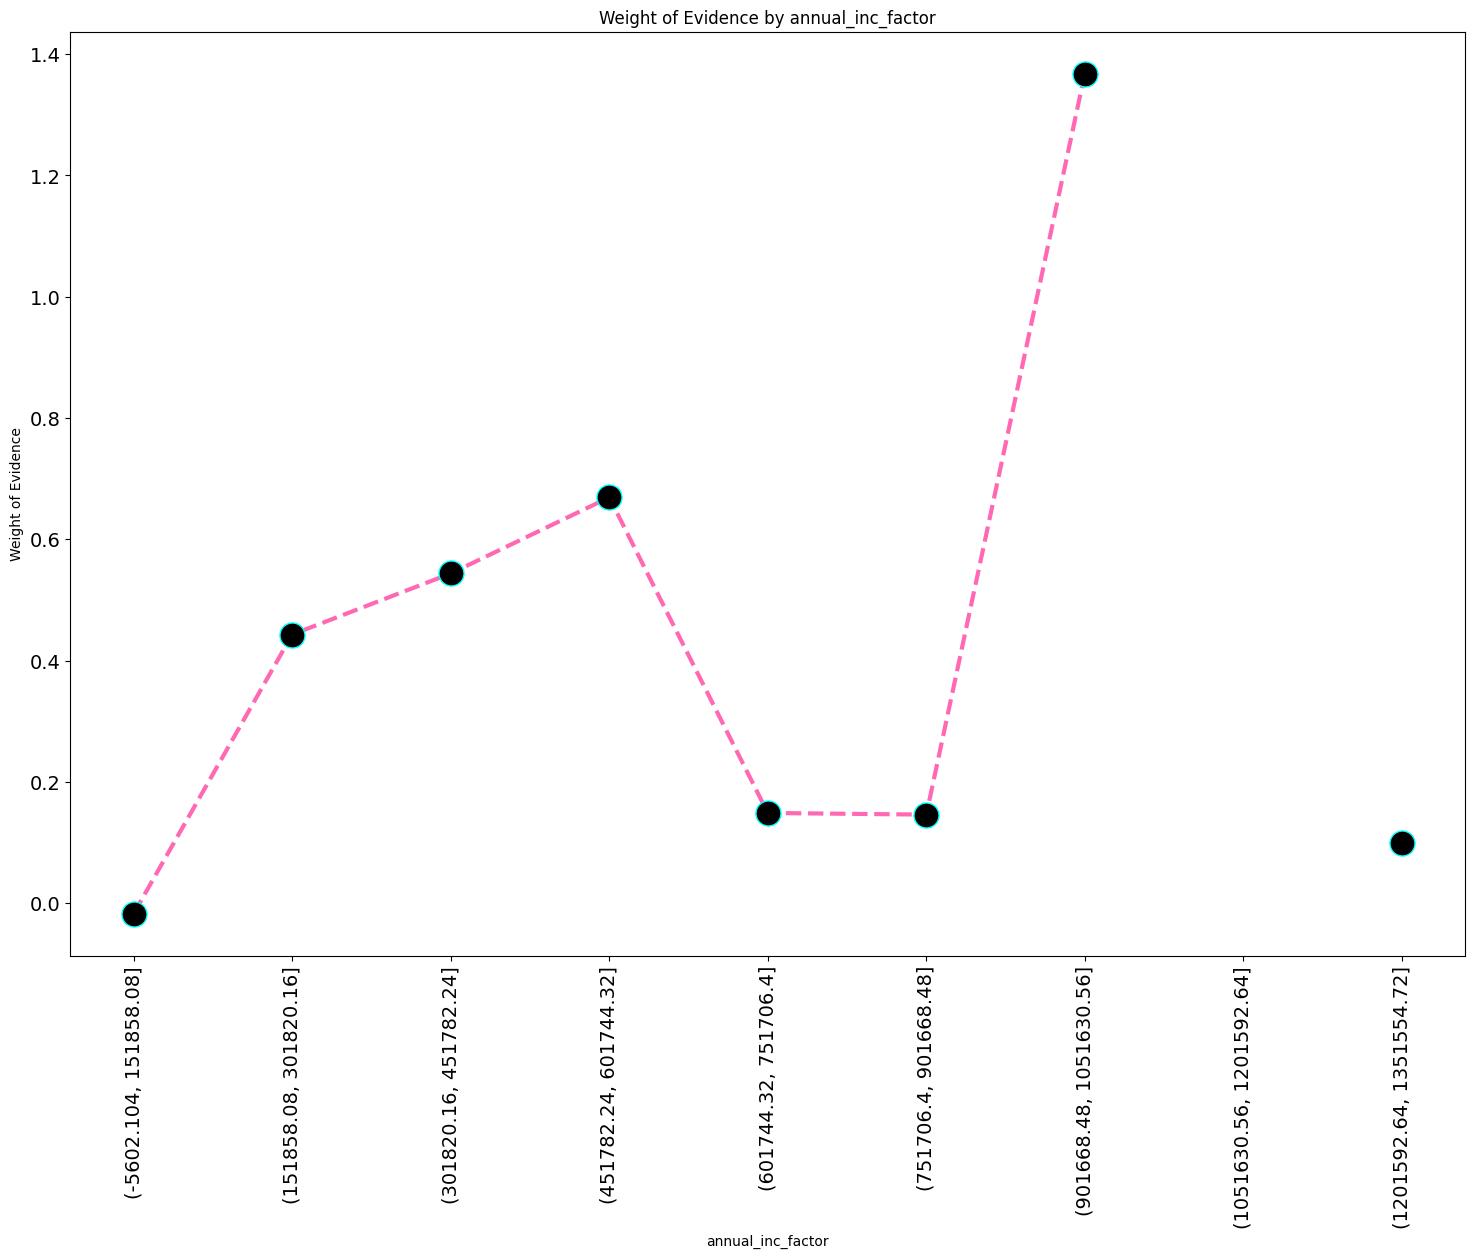

In [61]:
X['annual_inc_factor'] = pd.cut(X['annual_inc'], 50)
ann_inc_df = woe_continous(X, 'annual_inc_factor', y)
plot_by_woe(ann_inc_df, 90)

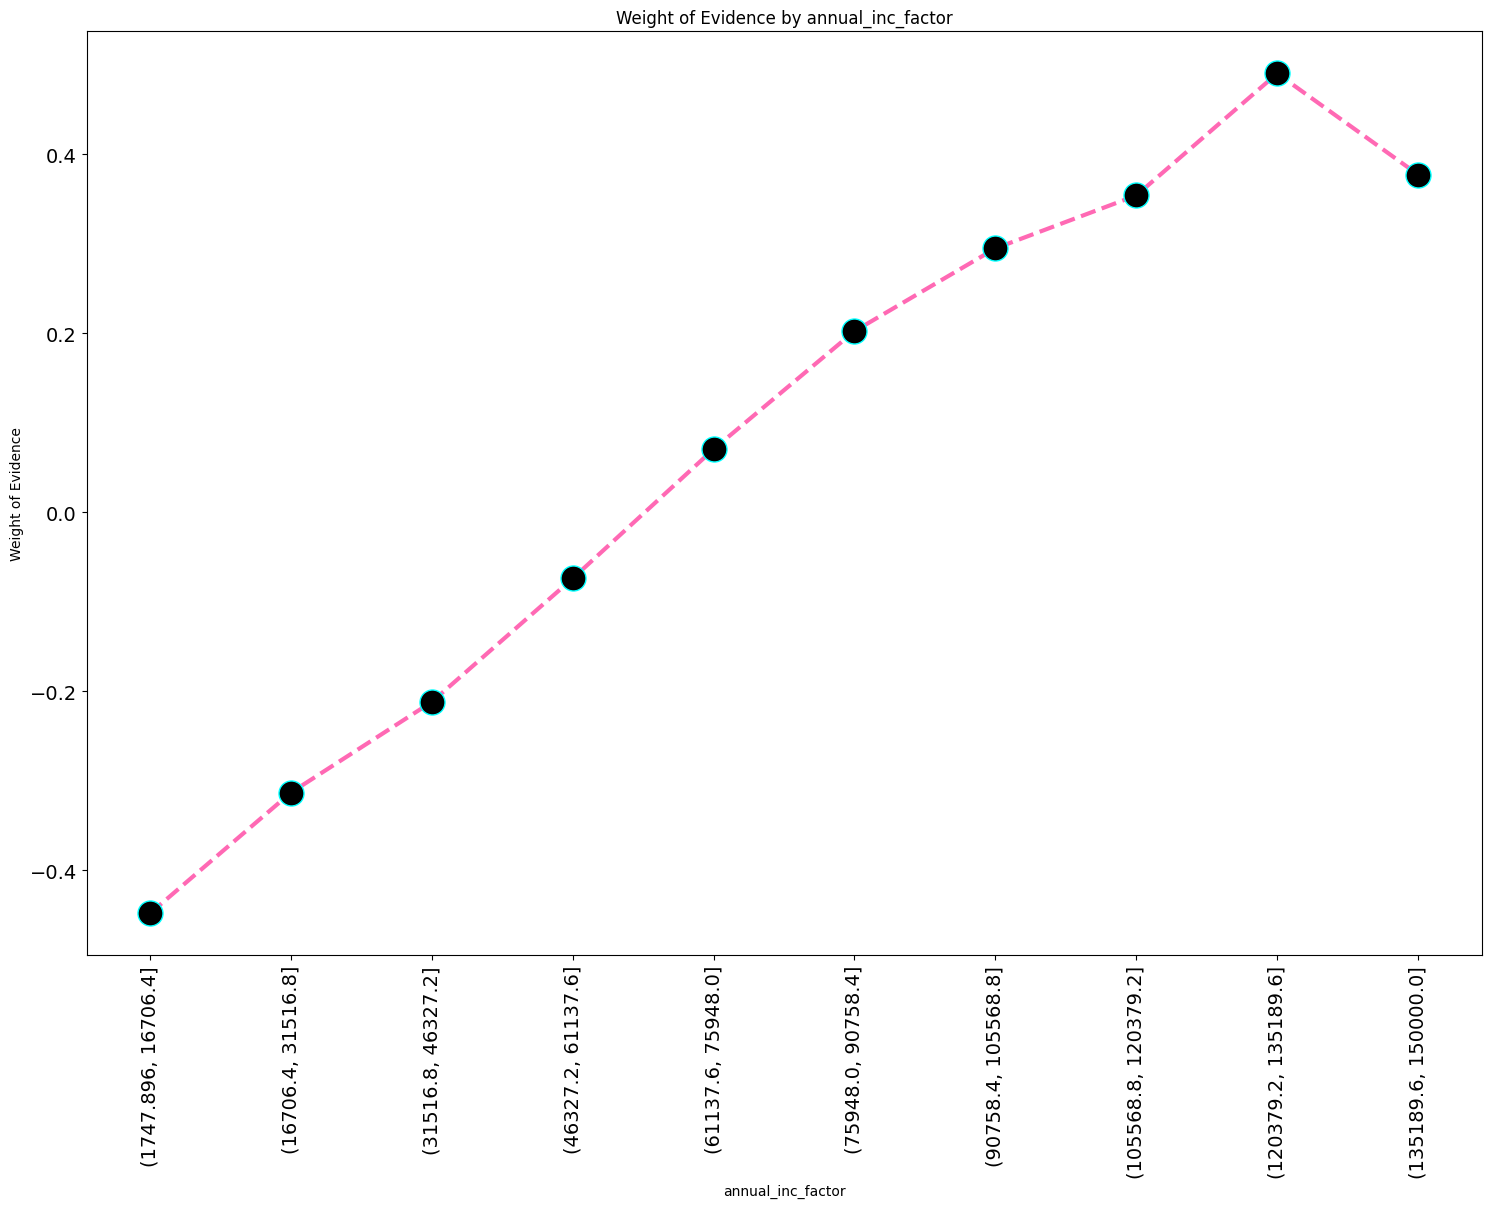

In [62]:
#Analyzing income  below 150000
X_train_prepr_temp = X[X['annual_inc'] <= 150000].copy()
# fine-classing
X_train_prepr_temp['annual_inc_factor'] = pd.cut(X_train_prepr_temp['annual_inc'], 10)
# select only the relevant index in the target col
df_temp = woe_continous(X_train_prepr_temp, 'annual_inc_factor', y[X_train_prepr_temp.index])
plot_by_woe(df_temp, 90)

- inq_last_6mths

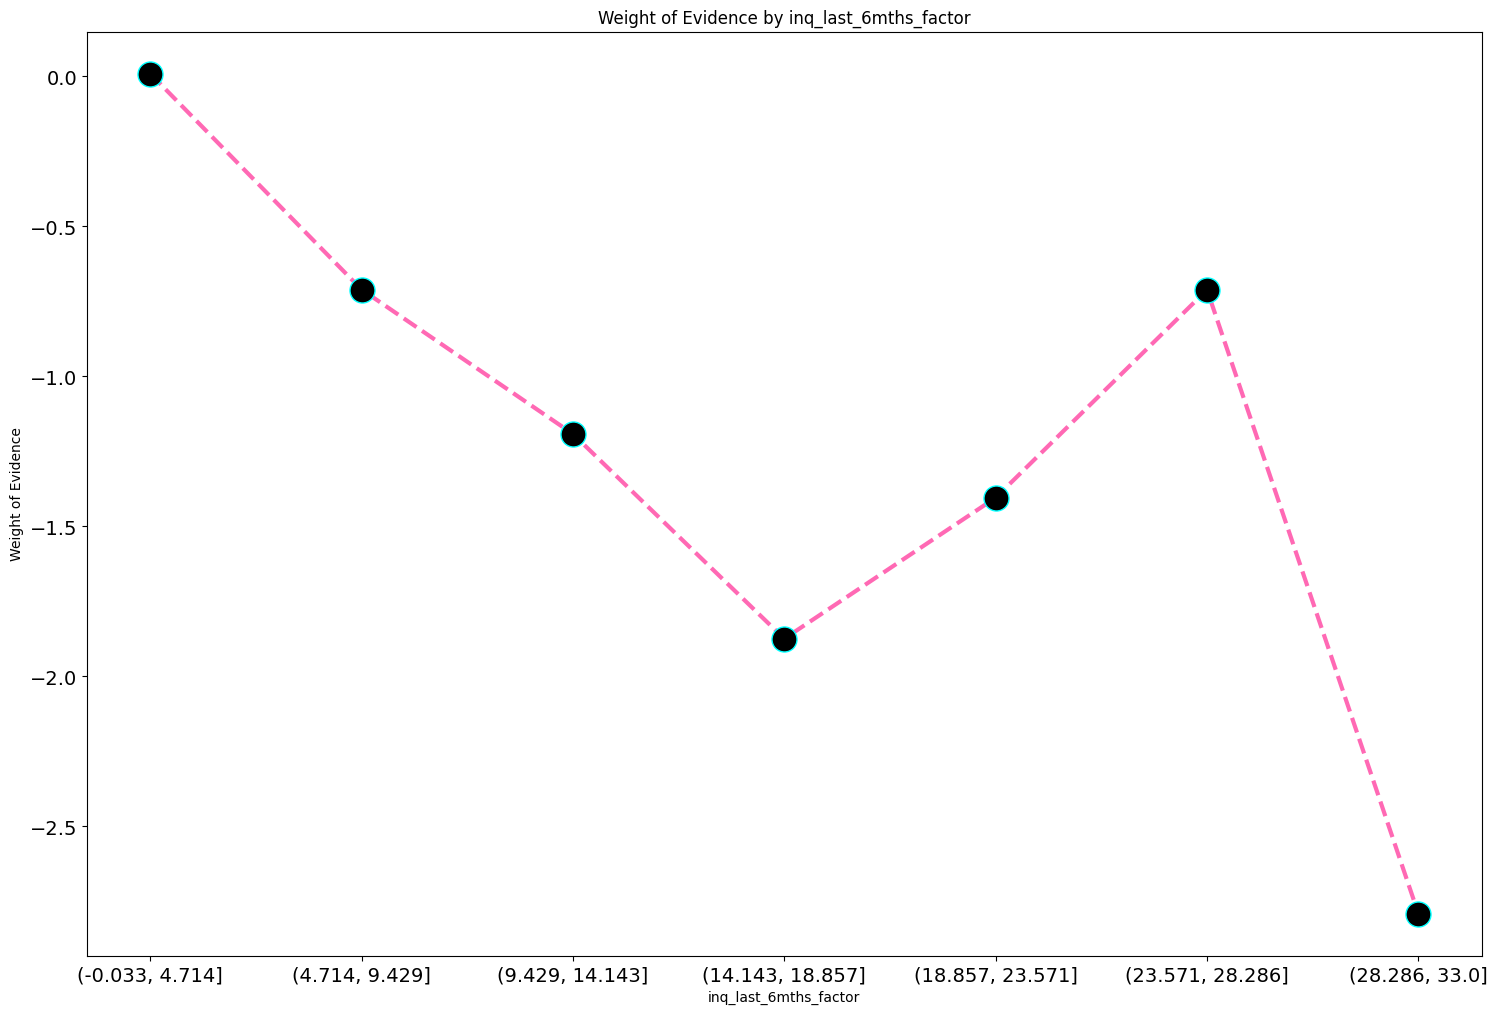

In [63]:
X['inq_last_6mths_factor'] = pd.cut(X['inq_last_6mths'], 7)
inq_fact_df = woe_continous(X, 'inq_last_6mths_factor', y)
plot_by_woe(inq_fact_df)

- tot_cur_bal

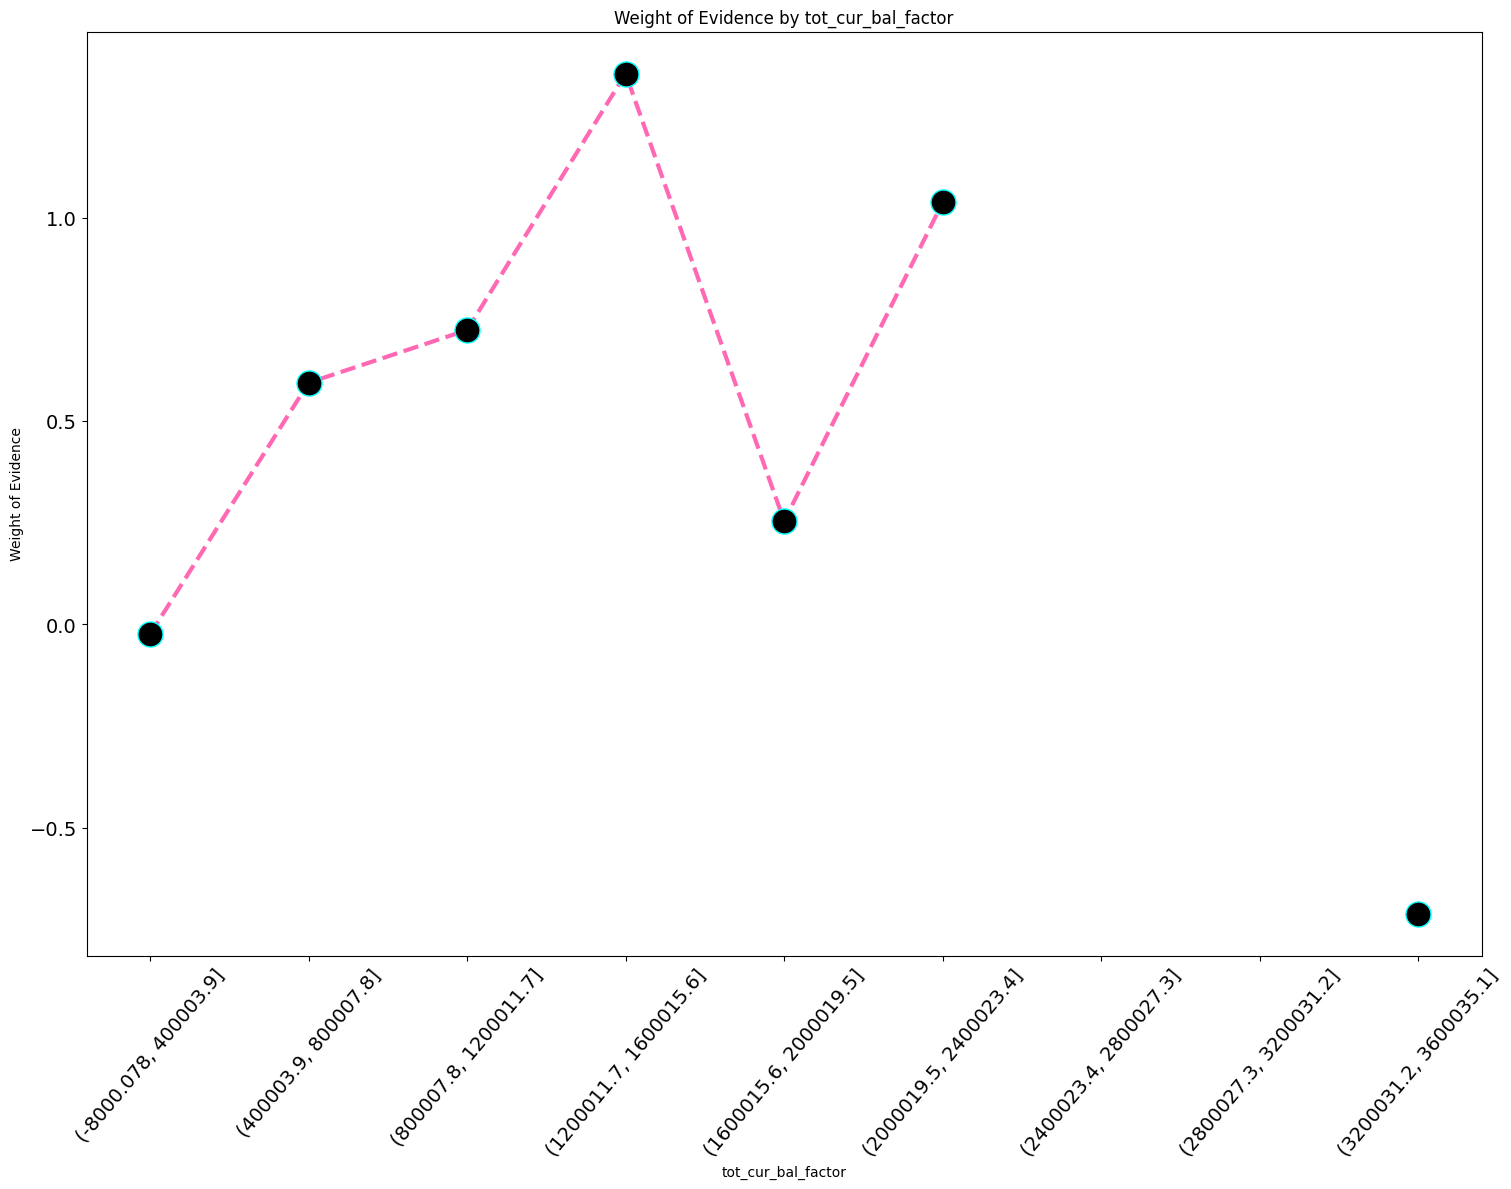

In [64]:
X['tot_cur_bal_factor'] = pd.cut(X['tot_cur_bal'], 20)
curr_bal_df = woe_continous(X, 'tot_cur_bal_factor', y)
plot_by_woe(curr_bal_df, 50)

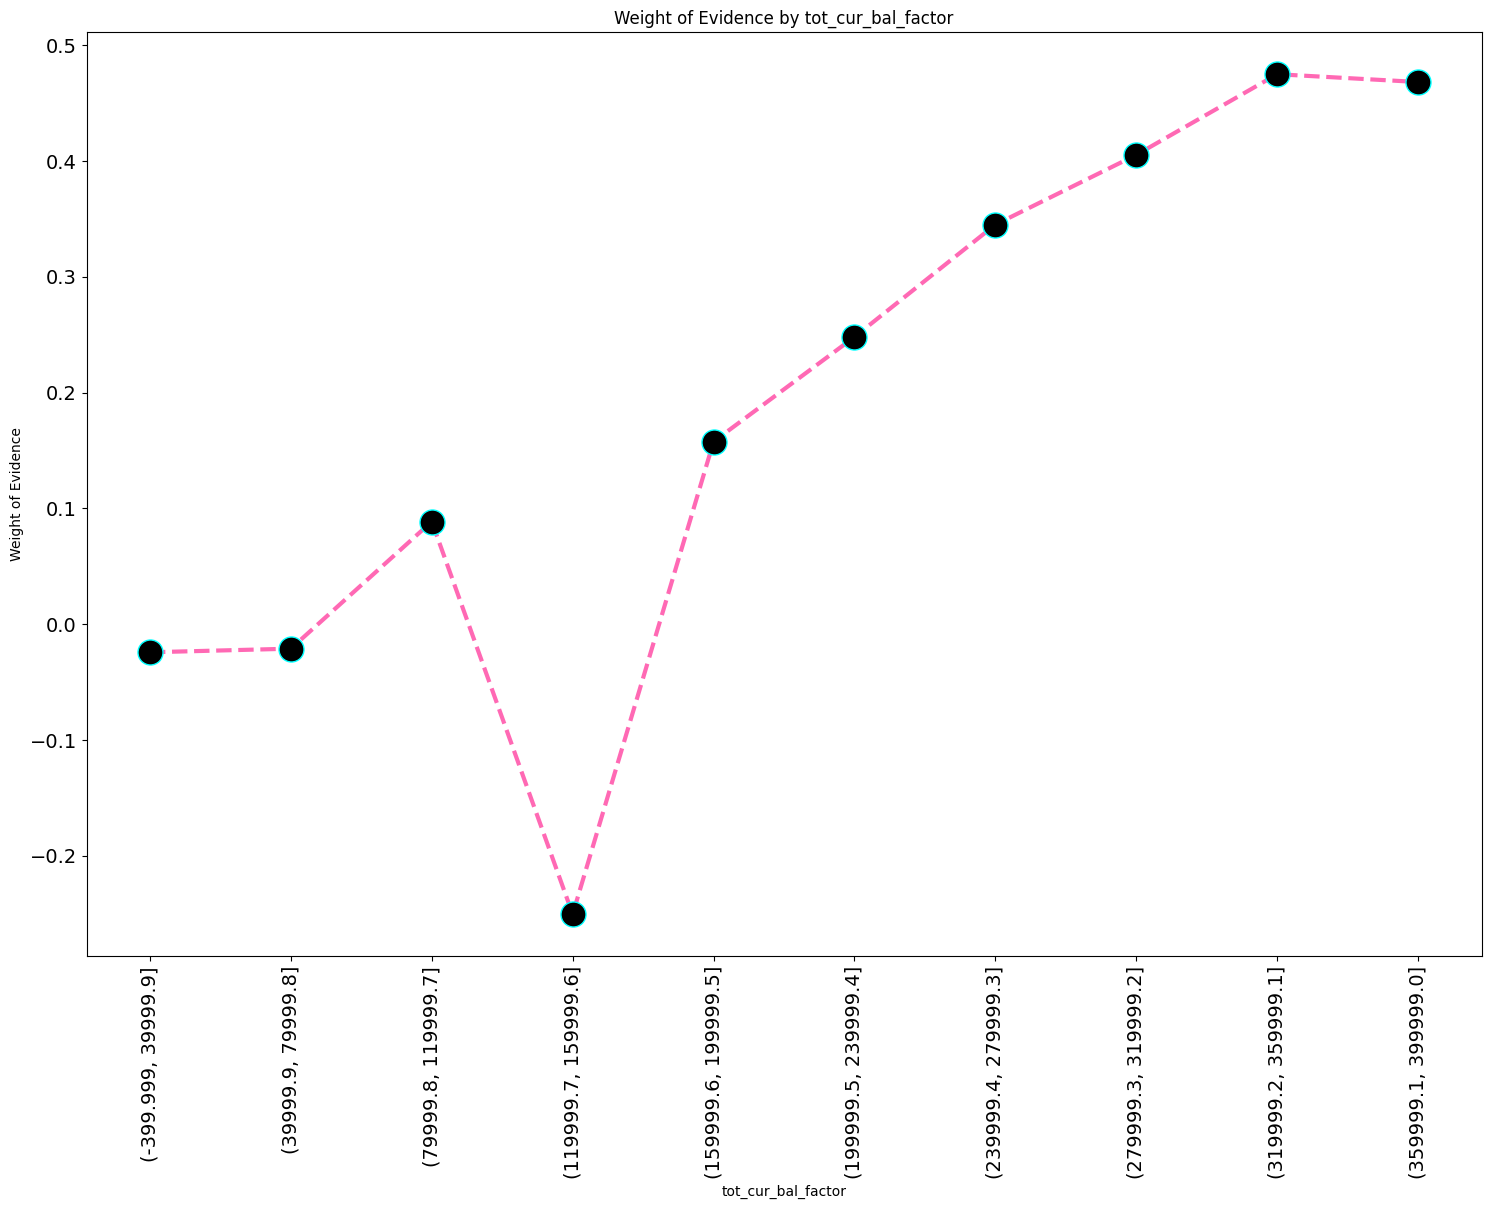

In [65]:
#Analyzing current balance  below 400000
X_train_prepr_temp = X[X['tot_cur_bal'] <= 400000].copy()
# fine-classing
X_train_prepr_temp['tot_cur_bal_factor'] = pd.cut(X_train_prepr_temp['tot_cur_bal'], 10)
# select only the relevant index in the target column
df_temp = woe_continous(X_train_prepr_temp, 'tot_cur_bal_factor', y[X_train_prepr_temp.index])
plot_by_woe(df_temp, 90)

- mths_since_last_credit_pull_d

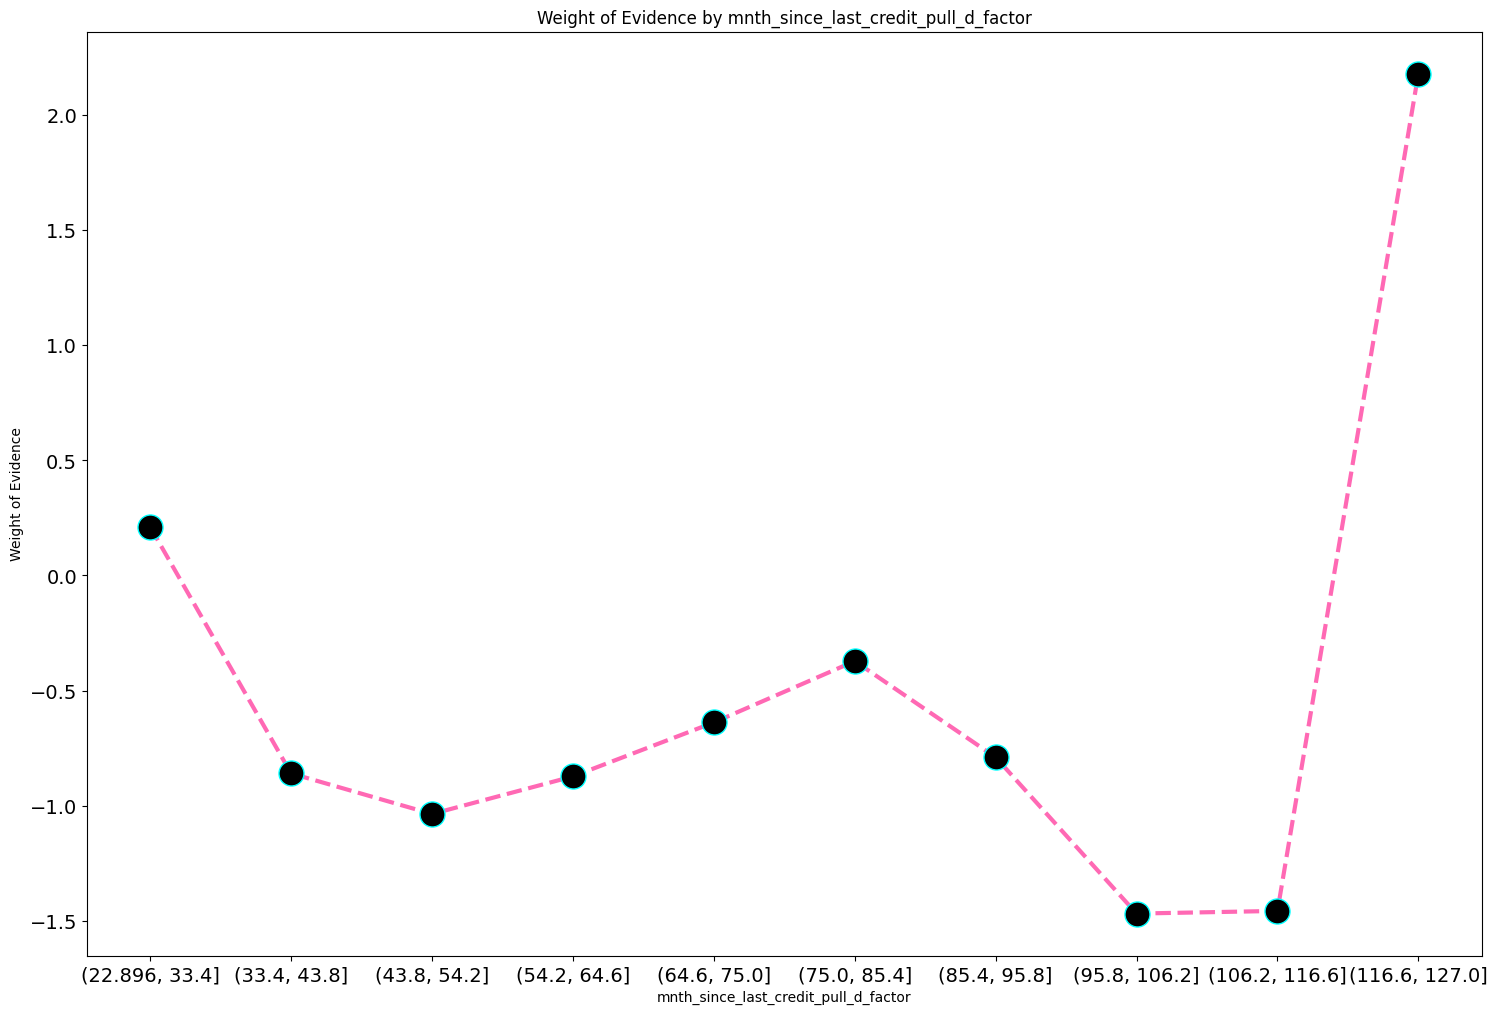

In [66]:
X['mnth_since_last_credit_pull_d_factor'] = pd.cut(X['mnth_since_last_credit_pull_d'], 10)
mths_cr_pull_df = woe_continous(X, 'mnth_since_last_credit_pull_d_factor', y)
plot_by_woe(mths_cr_pull_df)

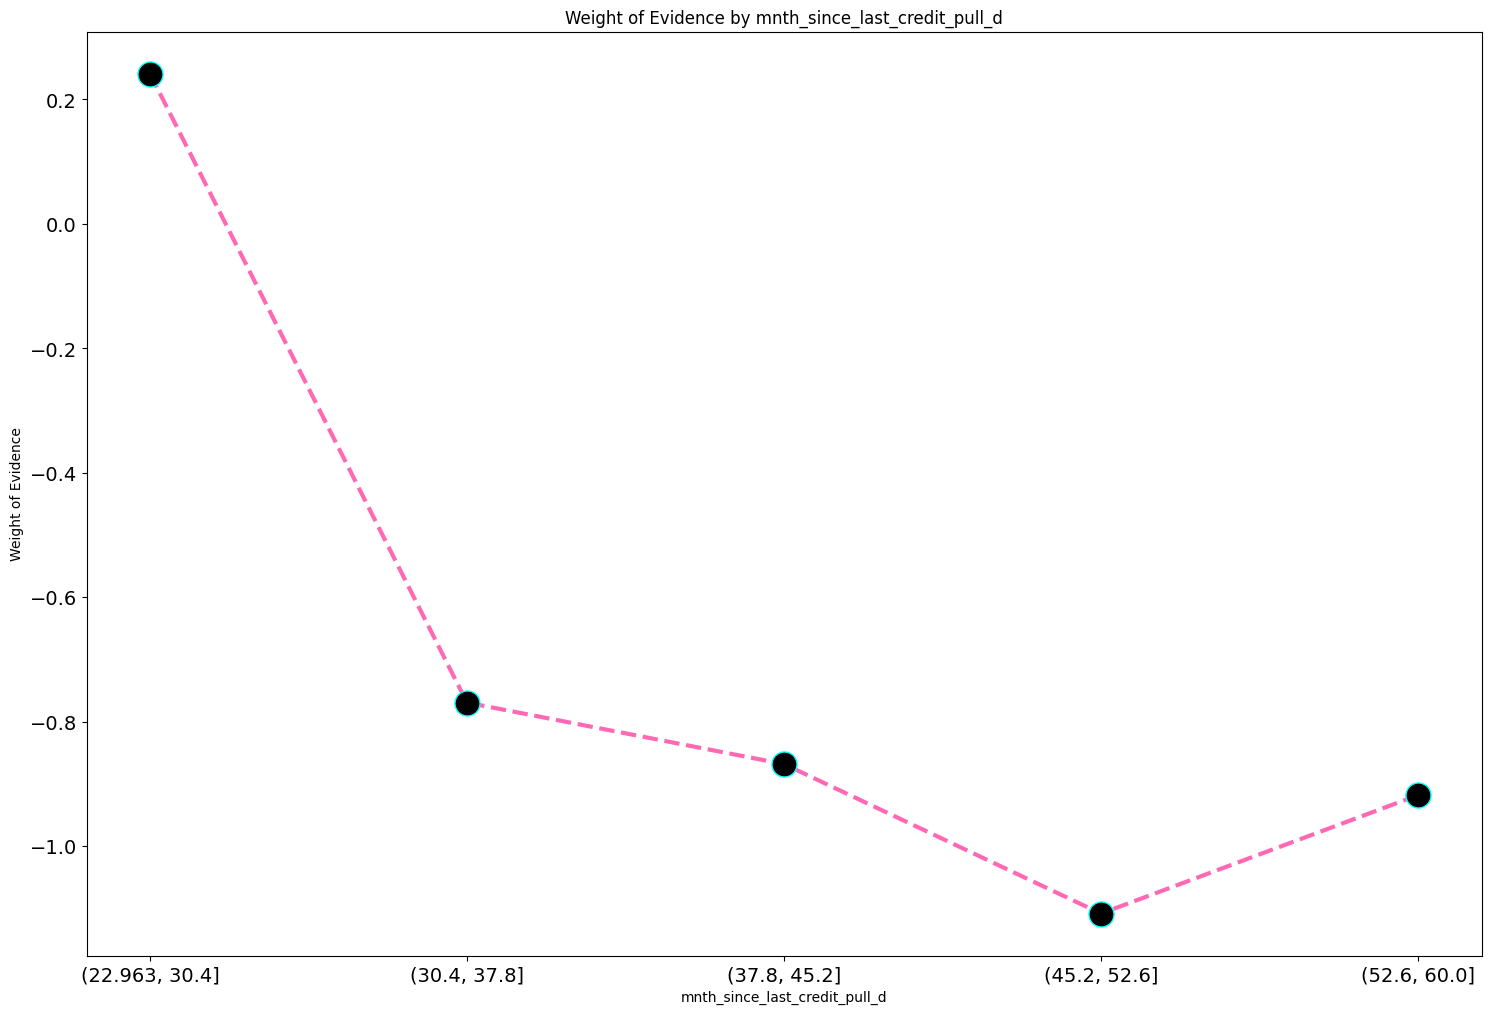

In [67]:
#Analyzing mths_since_credit_pull  below 60
X_train_prepr_temp = X[X['mnth_since_last_credit_pull_d'] <= 60].copy()
# fine-classing
X_train_prepr_temp['mnth_since_last_credit_pull_d'] = pd.cut(X_train_prepr_temp['mnth_since_last_credit_pull_d'], 5)
# select only the relevant index in the target column
df_temp = woe_continous(X_train_prepr_temp, 'mnth_since_last_credit_pull_d', y[X_train_prepr_temp.index])
plot_by_woe(df_temp)

- out_prncp

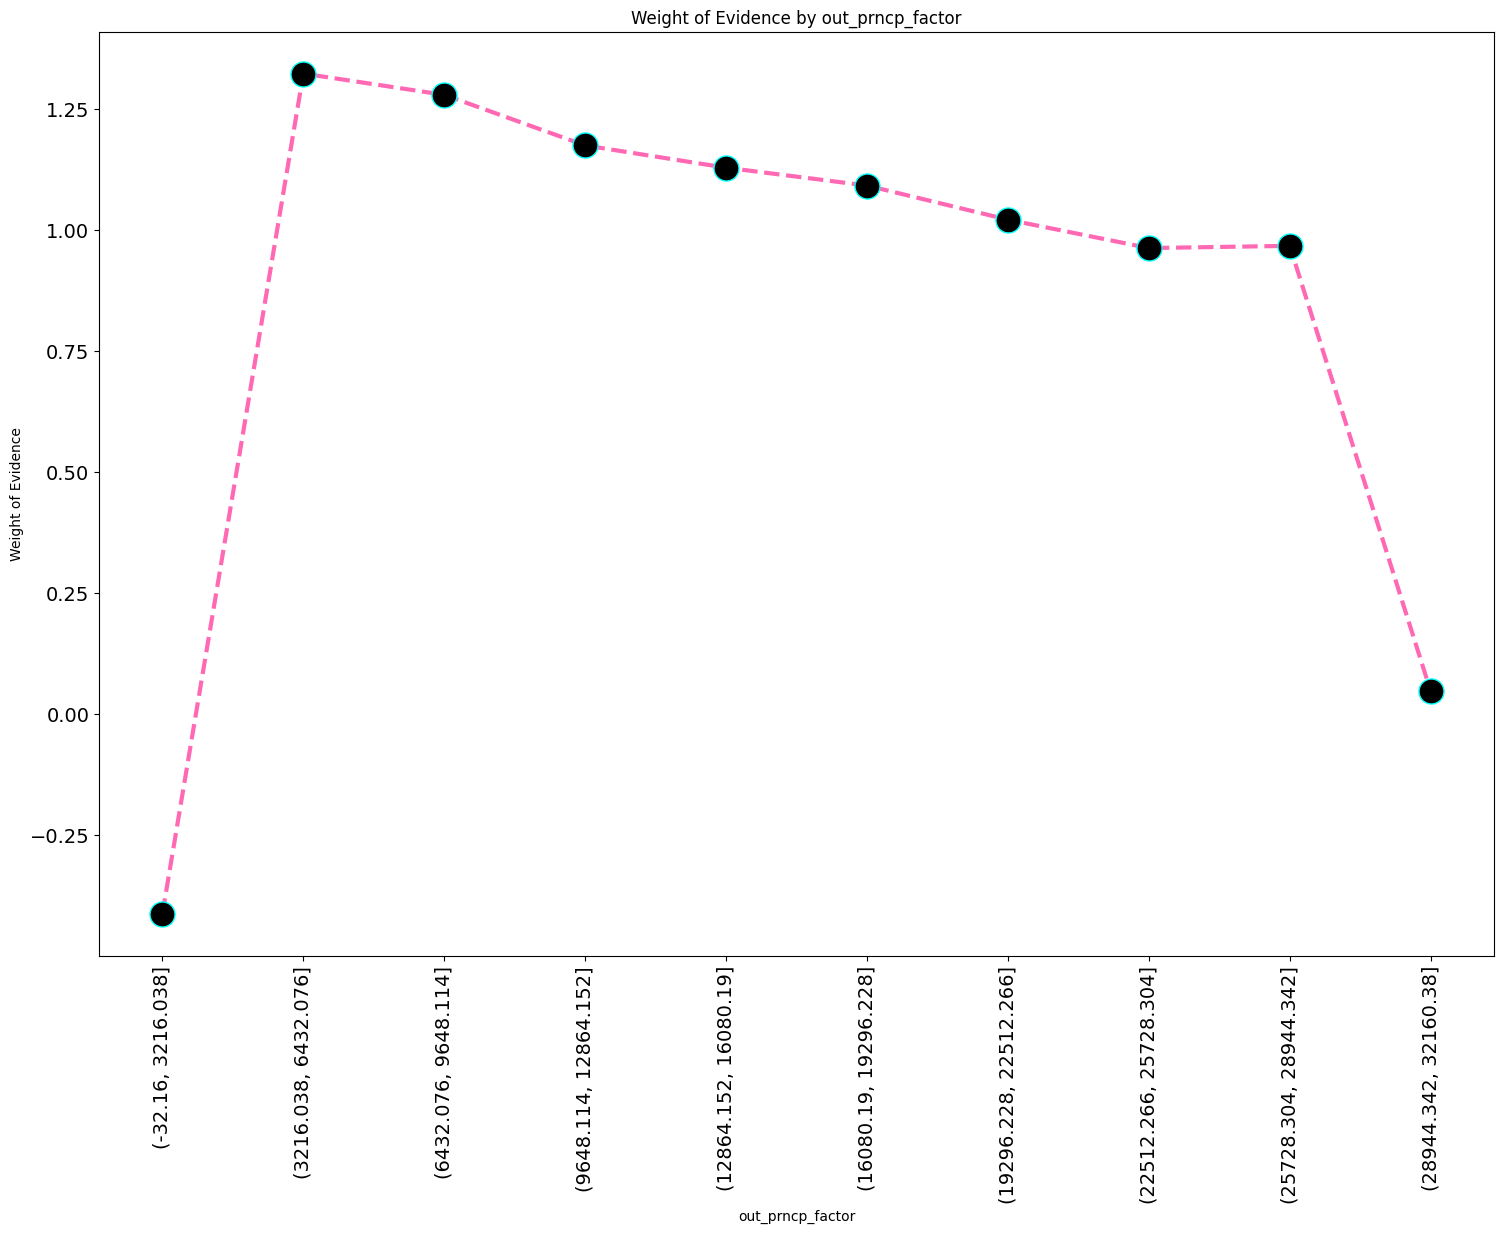

In [68]:
X['out_prncp_factor'] = pd.cut(X['out_prncp'], 10)
out_df = woe_continous(X, 'out_prncp_factor', y)
plot_by_woe(out_df, 90)

- mnth_since_issue_d

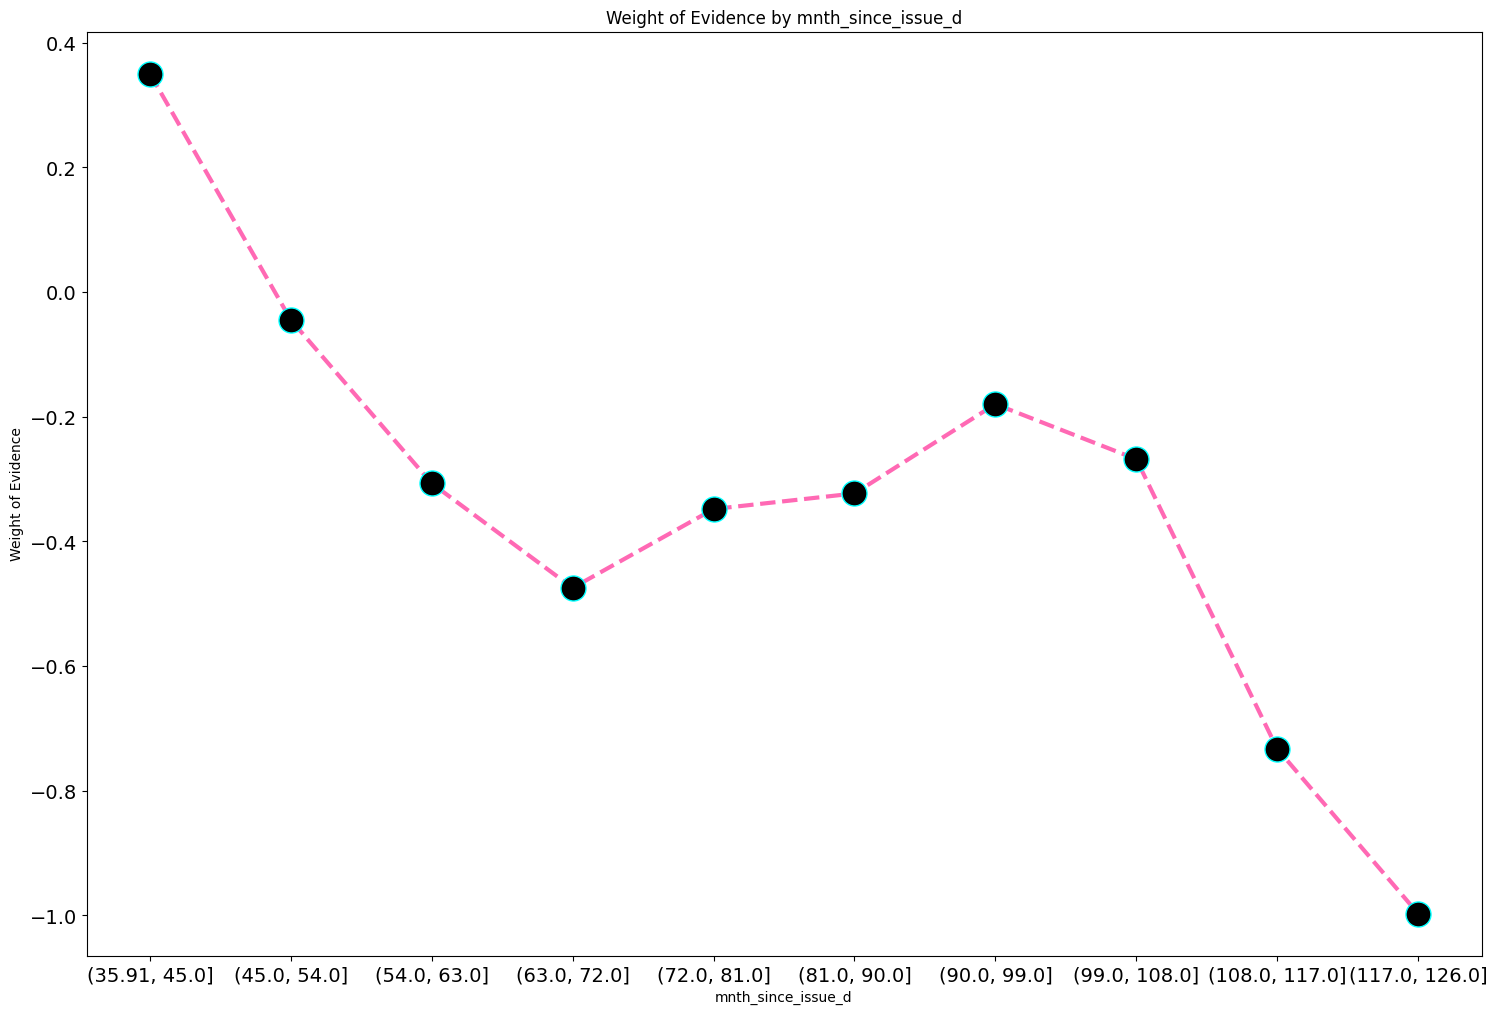

In [69]:
X['mnth_since_issue_d'] = pd.cut(X['mnth_since_issue_d'], 10)
iss_df = woe_continous(X, 'mnth_since_issue_d', y)
plot_by_woe(iss_df)

BINNING COLUMNS

---

In [70]:
# grade
df_train = preprocess_data.loc[:, 'grade:A':'grade:G']

In [71]:
# home_ownership 

df_train['home_ownership:OWN'] = preprocess_data.loc[:, 'home_ownership:OWN']
df_train['home_ownership:OTHER_NONE_RENT_ANY'] = sum([preprocess_data['home_ownership:OTHER'], 
                                                    preprocess_data['home_ownership:NONE'],
                                                    preprocess_data['home_ownership:RENT'], 
                                                    preprocess_data['home_ownership:ANY']])
df_train['home_ownership:MORTGAGE'] = preprocess_data.loc[:, 'home_ownership:MORTGAGE']

In [72]:
#verification status
df_train['verification_status:NOT_VERIFIED'] = preprocess_data.loc[:, 'verification_status:Not Verified']
df_train['verification_status:SOURCE_VERIFIED'] = preprocess_data.loc[:, 'verification_status:Source Verified']
df_train['verification_status:VERIFIED'] = preprocess_data.loc[:, 'verification_status:Verified']

In [73]:
# purpose of loan
df_train['purpose:SMALL_BUSINESS_EDUCATIONAL_RENEWABLE_ENERGY_MOVING'] = sum([preprocess_data['purpose:small_business'],  preprocess_data['purpose:renewable_energy'], preprocess_data['purpose:moving']])
df_train['purpose:OTHER_HOUSE_MEDICAL'] =sum([preprocess_data['purpose:other'], preprocess_data['purpose:house'], preprocess_data['purpose:medical']])
df_train ['purpose:WEDDING_VACATION'] = sum([preprocess_data['purpose:wedding'], preprocess_data['purpose:vacation']])
df_train ['purpose:HOME_IMPROVEMENT_MAJOR_PURCHASE'] = sum([preprocess_data['purpose:home_improvement'], preprocess_data['purpose:major_purchase']])
df_train ['purpose:CAR_CREDIT_CARD'] = sum([preprocess_data['purpose:car'], preprocess_data['purpose:credit_card']])

In [74]:
# addr state
df_train['addr_state:NE_IA_NV_HI_FL_AL'] =sum([preprocess_data['addr_state:IA'],preprocess_data['addr_state:NV'],
                                             preprocess_data['addr_state:HI'],preprocess_data['addr_state:FL'],
                                             preprocess_data['addr_state:AL']])

df_train['addr_state:NY'] = preprocess_data.loc[:, 'addr_state:NY']

df_train['addr_state:LA_NM_OK_NC_MO_MD_NJ_VA'] = sum([preprocess_data['addr_state:LA'],preprocess_data['addr_state:NM'],preprocess_data['addr_state:OK'],
                                                    preprocess_data['addr_state:NC'],preprocess_data['addr_state:MO'],preprocess_data['addr_state:MD'], 
                                                    preprocess_data['addr_state:NJ'],
                                                    preprocess_data['addr_state:VA']])

df_train['addr_state:CA'] = preprocess_data.loc[:,'addr_state:CA']

df_train['addr_state:AZ_MI_UT_TN_AR_PA'] =sum([preprocess_data['addr_state:AZ'],preprocess_data['addr_state:MI'],preprocess_data['addr_state:UT'],
                                             preprocess_data['addr_state:TN'],preprocess_data['addr_state:AR'],preprocess_data['addr_state:PA']])

df_train['addr_state:RI_OH_KY_DE_MN_SD_MA_IN'] =sum([preprocess_data['addr_state:RI'],preprocess_data['addr_state:OH'],preprocess_data['addr_state:KY'],
                                                   preprocess_data['addr_state:DE'],preprocess_data['addr_state:MN'],preprocess_data['addr_state:SD'],
                                                   preprocess_data['addr_state:MA'],
                                                   preprocess_data['addr_state:IN']])

df_train['addr_state:GA_WA'] = sum([preprocess_data['addr_state:GA'], preprocess_data['addr_state:WA']])

df_train['addr_state:WI_OR'] = sum([preprocess_data['addr_state:WI'], preprocess_data['addr_state:OR']])

df_train['addr_state:TX'] = preprocess_data.loc[:,'addr_state:TX']

df_train['addr_state:IL_CT_MT'] =sum([preprocess_data['addr_state:IL'],preprocess_data['addr_state:CT'],preprocess_data['addr_state:MT']])

df_train['addr_state:CO_SC'] = sum([preprocess_data['addr_state:CO'], preprocess_data['addr_state:SC']])

df_train['addr_state:KS_VT_AK_NS'] =sum([preprocess_data['addr_state:KS'],preprocess_data['addr_state:VT'],preprocess_data['addr_state:AK'], preprocess_data['addr_state:MS']])

df_train['addr_state:NH_WV_WY_DC'] =sum([preprocess_data['addr_state:NH'],preprocess_data['addr_state:WV'],preprocess_data['addr_state:WY'], preprocess_data['addr_state:DC']])

In [75]:
#initial_list_status
df_train['initial_list_status:F'] = preprocess_data.loc[:, 'initial_list_status:f']
df_train['initial_list_status:W'] = preprocess_data.loc[:, 'initial_list_status:w']

In [76]:
# term 
df_train['term:36'] = np.where((preprocess_data['term'] == 36), 1, 0)
df_train['term:60'] = np.where((preprocess_data['term']==60), 1,0)

In [77]:
#total_rec_int 
df_train['total_rec_int:<1000'] = np.where((preprocess_data['total_rec_int']<=1000), 1,0)
df_train['total_rec_int:1000-2000'] = np.where((preprocess_data['total_rec_int']>1000) &(preprocess_data['total_rec_int']<=2000), 1,0)
df_train['total_rec_int:2000-9000'] = np.where((preprocess_data['total_rec_int']>2000) &(preprocess_data['total_rec_int']<=9000), 1,0)
df_train['total_rec_int:>9000'] = np.where((preprocess_data['total_rec_int']>9000), 1,0)

In [78]:
#total_revol_hi_lim
df_train['total_rev_hi_lim:<10000'] =np.where((preprocess_data['total_rev_hi_lim']<=10000),1,0)
df_train['total_rev_hi_lim:10000-20000'] =np.where((preprocess_data['total_rev_hi_lim']>10000)&(preprocess_data['total_rev_hi_lim']<=20000),1,0)
df_train['total_rev_hi_lim:20000-40000'] =np.where((preprocess_data['total_rev_hi_lim']>20000)&(preprocess_data['total_rev_hi_lim']<=40000),1,0)
df_train['total_rev_hi_lim:40000-60000'] =np.where((preprocess_data['total_rev_hi_lim']>40000)&(preprocess_data['total_rev_hi_lim']<=60000),1,0)
df_train['total_rev_hi_lim:60000-80000'] =np.where((preprocess_data['total_rev_hi_lim']>60000)&(preprocess_data['total_rev_hi_lim']<=80000),1,0)
df_train['total_rev_hi_lim:80000-100000'] =np.where((preprocess_data['total_rev_hi_lim']>80000)&(preprocess_data['total_rev_hi_lim']<=100000),1,0)
df_train['total_rev_hi_lim:<100000'] =np.where((preprocess_data['total_rev_hi_lim']>100000),1,0)

In [79]:
#total_pymnt
df_train['total_pymnt:<5000'] = np.where((preprocess_data['total_pymnt']<=5000), 1,0)
df_train['total_pymnt:5000-11000'] = np.where((preprocess_data['total_pymnt']>5000)&(preprocess_data['total_pymnt']<=11000),1,0)
df_train['total_pymnt:11000-16000'] = np.where((preprocess_data['total_pymnt']>11000)&(preprocess_data['total_pymnt']<=16000),1,0)
df_train['total_pymnt:16000-22000'] = np.where((preprocess_data['total_pymnt']>16000)&(preprocess_data['total_pymnt']<=22000),1,0)
df_train['total_pymnt:>22000'] = np.where((preprocess_data['total_pymnt']<=5000), 1,0)

In [80]:
#int_Rate

df_train['int_rate:<7.484'] = np.where((preprocess_data['int_rate'] <= 7.484), 1, 0)
df_train['int_rate:7.484-9.548'] = np.where((preprocess_data['int_rate'] > 7.484) & (preprocess_data['int_rate'] <= 9.548), 1, 0)
df_train['int_rate:9.548-11.612'] = np.where((preprocess_data['int_rate'] > 9.548) & (preprocess_data['int_rate'] <= 11.612), 1, 0)
df_train['int_rate:11.612-13.676'] = np.where((preprocess_data['int_rate'] > 11.612) & (preprocess_data['int_rate'] <= 13.676), 1, 0)
df_train['int_rate:13.676-15.74'] = np.where((preprocess_data['int_rate'] > 13.676) & (preprocess_data['int_rate'] <= 15.74), 1, 0)
df_train['int_rate:15.74-17.804'] = np.where((preprocess_data['int_rate'] > 15.74) & (preprocess_data['int_rate'] <= 17.804), 1, 0)
df_train['int_rate:17.804-19.868'] = np.where((preprocess_data['int_rate'] > 17.804) & (preprocess_data['int_rate'] <= 19.868), 1, 0)
df_train['int_rate:7.19.868-21.932'] = np.where((preprocess_data['int_rate'] > 19.868) & (preprocess_data['int_rate'] <= 21.932), 1, 0)
df_train['int_rate:21.932-26.06'] = np.where((preprocess_data['int_rate'] > 21.932) & (preprocess_data['int_rate'] <= 26.06), 1, 0)


In [81]:
#dti 
df_train['dti:<4'] = np.where((preprocess_data['dti'] <=4), 1, 0)
df_train['dti:4-8'] = np.where((preprocess_data['dti'] > 4) & (preprocess_data['dti'] <= 8), 1, 0)
df_train['dti:8-12'] = np.where((preprocess_data['dti'] > 8) & (preprocess_data['dti'] <= 12), 1, 0)
df_train['dti:12-16'] = np.where((preprocess_data['dti'] > 12) & (preprocess_data['dti'] <= 16), 1, 0)
df_train['dti:16-20'] = np.where((preprocess_data['dti'] > 16) & (preprocess_data['dti'] <= 20), 1, 0)
df_train['dti:20-23'] = np.where((preprocess_data['dti'] > 20) & (preprocess_data['dti'] <= 23), 1, 0)
df_train['dti:23-27'] = np.where((preprocess_data['dti'] > 23) & (preprocess_data['dti'] <= 27), 1, 0)
df_train['dti:27-40'] = np.where((preprocess_data['dti'] > 27) & (preprocess_data['dti'] <= 40), 1, 0)

In [82]:
#annual income 
df_train['annual_inc:<32000'] = np.where((preprocess_data['annual_inc'] <= 32000), 1, 0)
df_train['annual_inc:32000-50000'] = np.where((preprocess_data['annual_inc'] > 32000) & (preprocess_data['annual_inc'] <= 50000),1, 0)
df_train['annual_inc:32000-50000'] = np.where((preprocess_data['annual_inc'] > 32000) & (preprocess_data['annual_inc'] <= 50000), 1, 0)
df_train['annual_inc:50000-60000'] = np.where((preprocess_data['annual_inc'] > 50000) & (preprocess_data['annual_inc'] <= 60000), 1, 0)
df_train['annual_inc:60000-75000'] = np.where((preprocess_data['annual_inc'] > 60000) & (preprocess_data['annual_inc'] <= 75000), 1, 0)
df_train['annual_inc:75000-90000'] = np.where((preprocess_data['annual_inc'] > 75000) & (preprocess_data['annual_inc'] <= 90000), 1, 0)
df_train['annual_inc:90000-120000'] = np.where((preprocess_data['annual_inc'] > 90000) & (preprocess_data['annual_inc'] <= 120000), 1, 0)
df_train['annual_inc:120000-135000'] = np.where((preprocess_data['annual_inc'] > 120000) & (preprocess_data['annual_inc'] <= 135000), 1, 0)
df_train['annual_inc:135000-150000'] = np.where((preprocess_data['annual_inc'] > 135000) & (preprocess_data['annual_inc'] <= 150000), 1, 0)
df_train['annual_inc:>150000'] = np.where((preprocess_data['annual_inc'] > 150000), 1, 0)

In [83]:
#inq_last_6mths
df_train['inq_last_6mths:<1'] = np.where((preprocess_data['inq_last_6mths'] <=1), 1, 0)
df_train['inq_last_6mths:1-2'] = np.where((preprocess_data['inq_last_6mths'] >1)& (preprocess_data['inq_last_6mths']<=2),  1, 0)
df_train['inq_last_6mths:2-4'] = np.where((preprocess_data['inq_last_6mths'] >2)& (preprocess_data['inq_last_6mths']<=4),  1, 0)
df_train['inq_last_6mths:4-7'] = np.where((preprocess_data['inq_last_6mths'] >4)& (preprocess_data['inq_last_6mths']<=7),  1, 0)

In [84]:
#tot_cur_balance
df_train['tot_cur_bal:<40000'] = np.where((preprocess_data['tot_cur_bal'] <= 40000), 1, 0)
df_train['tot_cur_bal:40000-80000'] = np.where((preprocess_data['tot_cur_bal'] > 40000) & (preprocess_data['tot_cur_bal'] <= 80000), 1, 0)
df_train['tot_cur_bal:80000-120000'] = np.where((preprocess_data['tot_cur_bal'] > 120000) & (preprocess_data['tot_cur_bal'] <= 160000), 1, 0)
df_train['tot_cur_bal:120000-160000'] = np.where((preprocess_data['tot_cur_bal'] > 120000) & (preprocess_data['tot_cur_bal'] <= 160000), 1, 0)
df_train['tot_cur_bal:160000-200000'] = np.where((preprocess_data['tot_cur_bal'] > 160000) & (preprocess_data['tot_cur_bal'] <= 200000), 1, 0)
df_train['tot_cur_bal:200000-240000'] = np.where((preprocess_data['tot_cur_bal'] > 200000) & (preprocess_data['tot_cur_bal'] <= 240000), 1, 0)
df_train['tot_cur_bal:240000-320000'] = np.where((preprocess_data['tot_cur_bal'] > 240000) & (preprocess_data['tot_cur_bal'] <= 320000), 1, 0)
df_train['tot_cur_bal:320000-400000'] = np.where((preprocess_data['tot_cur_bal'] > 320000) & (preprocess_data['tot_cur_bal'] <= 400000), 1, 0)
df_train['tot_cur_bal:>400000'] = np.where((preprocess_data['tot_cur_bal'] > 400000), 1, 0)


In [85]:
#mnth_since_last_credit_pull_d
df_train['mnth_since_last_credit_pull_d:<65'] = np.where((preprocess_data['mnth_since_last_credit_pull_d']<=65), 1,0)
df_train['mnth_since_last_credit_pull_d:65-76'] = np.where((preprocess_data['mnth_since_last_credit_pull_d']>65)&(preprocess_data['mnth_since_last_credit_pull_d']<=76),1,0)
df_train['mnth_since_last_credit_pull_d:>76'] = np.where((preprocess_data['mnth_since_last_credit_pull_d']>76), 1,0)

In [86]:
#mnth_since_issue_d_factor
df_train['mnth_since_issue_d:<70.8'] = np.where((preprocess_data['mnth_since_issue_d']<=70.8), 1,0)
df_train['mnth_since_issue_d:>70.8-73.6'] = np.where((preprocess_data['mnth_since_issue_d'] >70.8) & (preprocess_data['mnth_since_issue_d']<=73.6), 1,0)
df_train['mnth_since_issue_d:73.6-76.4'] = np.where((preprocess_data['mnth_since_issue_d']>70.8) & (preprocess_data['mnth_since_issue_d']<=76.4), 1,0)
df_train['mnth_since_issue_d:>76.4-79.2'] = np.where((preprocess_data['mnth_since_issue_d'] >76.4) & (preprocess_data['mnth_since_issue_d']<=79.2), 1,0)
df_train['mnth_since_issue_d:>79.2-82'] = np.where((preprocess_data['mnth_since_issue_d'] >79.2) & (preprocess_data['mnth_since_issue_d']<=82), 1,0)
df_train['mnth_since_issue_d>82-84'] = np.where((preprocess_data['mnth_since_issue_d'] >82) & (preprocess_data['mnth_since_issue_d']<=84), 1,0)
df_train['mnth_since_issue_d:>84-90.4'] = np.where((preprocess_data['mnth_since_issue_d'] >84) & (preprocess_data['mnth_since_issue_d']<=90.4), 1,0)
df_train['mnth_since_issue_d:>90.4-96'] = np.where((preprocess_data['mnth_since_issue_d'] >90.4) & (preprocess_data['mnth_since_issue_d']<=96), 1,0)

In [87]:
#out_prncp
df_train['out_prncp:<3000'] = np.where((preprocess_data['out_prncp']<=3000), 1,0)
df_train['out_prncp:3000-6000'] = np.where((preprocess_data['out_prncp']>3000)&(preprocess_data['out_prncp']<=6000), 1,0)
df_train['out_prncp:6000-10000'] = np.where((preprocess_data['out_prncp']>6000)&(preprocess_data['out_prncp']<=10000), 1,0)
df_train['out_prncp:10000-12000'] = np.where((preprocess_data['out_prncp']>10000)&(preprocess_data['out_prncp']<=12000), 1,0)
df_train['out_prncp:>12000'] = np.where((preprocess_data['out_prncp']>12000), 1,0)

In [88]:
df_train['bad_loan'] = preprocess_data.loc[:, 'bad_loan']

In [89]:
pd.options.display.max_columns = None
df_train.head(10)

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:OWN,home_ownership:OTHER_NONE_RENT_ANY,home_ownership:MORTGAGE,verification_status:NOT_VERIFIED,verification_status:SOURCE_VERIFIED,verification_status:VERIFIED,purpose:SMALL_BUSINESS_EDUCATIONAL_RENEWABLE_ENERGY_MOVING,purpose:OTHER_HOUSE_MEDICAL,purpose:WEDDING_VACATION,purpose:HOME_IMPROVEMENT_MAJOR_PURCHASE,purpose:CAR_CREDIT_CARD,addr_state:NE_IA_NV_HI_FL_AL,addr_state:NY,addr_state:LA_NM_OK_NC_MO_MD_NJ_VA,addr_state:CA,addr_state:AZ_MI_UT_TN_AR_PA,addr_state:RI_OH_KY_DE_MN_SD_MA_IN,addr_state:GA_WA,addr_state:WI_OR,addr_state:TX,addr_state:IL_CT_MT,addr_state:CO_SC,addr_state:KS_VT_AK_NS,addr_state:NH_WV_WY_DC,initial_list_status:F,initial_list_status:W,term:36,term:60,total_rec_int:<1000,total_rec_int:1000-2000,total_rec_int:2000-9000,total_rec_int:>9000,total_rev_hi_lim:<10000,total_rev_hi_lim:10000-20000,total_rev_hi_lim:20000-40000,total_rev_hi_lim:40000-60000,total_rev_hi_lim:60000-80000,total_rev_hi_lim:80000-100000,total_rev_hi_lim:<100000,total_pymnt:<5000,total_pymnt:5000-11000,total_pymnt:11000-16000,total_pymnt:16000-22000,total_pymnt:>22000,int_rate:<7.484,int_rate:7.484-9.548,int_rate:9.548-11.612,int_rate:11.612-13.676,int_rate:13.676-15.74,int_rate:15.74-17.804,int_rate:17.804-19.868,int_rate:7.19.868-21.932,int_rate:21.932-26.06,dti:<4,dti:4-8,dti:8-12,dti:12-16,dti:16-20,dti:20-23,dti:23-27,dti:27-40,annual_inc:<32000,annual_inc:32000-50000,annual_inc:50000-60000,annual_inc:60000-75000,annual_inc:75000-90000,annual_inc:90000-120000,annual_inc:120000-135000,annual_inc:135000-150000,annual_inc:>150000,inq_last_6mths:<1,inq_last_6mths:1-2,inq_last_6mths:2-4,inq_last_6mths:4-7,tot_cur_bal:<40000,tot_cur_bal:40000-80000,tot_cur_bal:80000-120000,tot_cur_bal:120000-160000,tot_cur_bal:160000-200000,tot_cur_bal:200000-240000,tot_cur_bal:240000-320000,tot_cur_bal:320000-400000,tot_cur_bal:>400000,mnth_since_last_credit_pull_d:<65,mnth_since_last_credit_pull_d:65-76,mnth_since_last_credit_pull_d:>76,mnth_since_issue_d:<70.8,mnth_since_issue_d:>70.8-73.6,mnth_since_issue_d:73.6-76.4,mnth_since_issue_d:>76.4-79.2,mnth_since_issue_d:>79.2-82,mnth_since_issue_d>82-84,mnth_since_issue_d:>84-90.4,mnth_since_issue_d:>90.4-96,out_prncp:<3000,out_prncp:3000-6000,out_prncp:6000-10000,out_prncp:10000-12000,out_prncp:>12000,bad_loan
0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
4,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
5,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
6,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1
7,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0

BUILD MODEL

---

split data into train and test

In [90]:
df_train1 = df_train.copy()

In [91]:
X = df_train1.drop(columns='bad_loan', axis=1)
y = df_train1['bad_loan']

In [92]:
# Membagi data menjadi training dan testing set
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Ubah semua -1.0 menjadi 0 agar kompatibel dengan semua model (terutama XGBoost)
y_train = y_train.replace(-1.0, 0)
y_test = y_test.replace(-1.0, 0)

training model and evaluating

In [93]:
# Random Forest Classifier
randof = RandomForestClassifier(random_state = 42)
randof.fit(x_train, y_train)
y_pred = randof.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.34      0.46     12750
           1       0.92      0.99      0.95    103822

    accuracy                           0.91    116572
   macro avg       0.83      0.66      0.71    116572
weighted avg       0.90      0.91      0.90    116572



In [94]:
# Decision Tree Classifier
dtree = DecisionTreeClassifier(random_state = 42)
dtree = dtree.fit(x_train, y_train)
y_pred = dtree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.44      0.42     12750
           1       0.93      0.92      0.93    103822

    accuracy                           0.87    116572
   macro avg       0.67      0.68      0.67    116572
weighted avg       0.87      0.87      0.87    116572



In [99]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.24      0.33     12750
           1       0.91      0.98      0.94    103822

    accuracy                           0.90    116572
   macro avg       0.73      0.61      0.64    116572
weighted avg       0.87      0.90      0.88    116572



In [ ]:
# Clean feature names in x_train and x_test
x_train.columns = [str(col).replace('[', '_').replace(']', '_').replace('<', '_') for col in x_train.columns]
x_test.columns = [str(col).replace('[', '_').replace(']', '_').replace('<', '_') for col in x_test.columns]

# Now train the XGBoost model
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.35      0.49     12750
           1       0.93      0.99      0.96    103822

    accuracy                           0.92    116572
   macro avg       0.85      0.67      0.72    116572
weighted avg       0.91      0.92      0.90    116572



In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.31      0.43     12750
           1       0.92      0.99      0.95    103822

    accuracy                           0.91    116572
   macro avg       0.83      0.65      0.69    116572
weighted avg       0.90      0.91      0.90    116572



Check Overfitting

In [ ]:
columns = ['mnth_since_last_pymnt_d','last_pymnt_amnt','recoveries_label_Paid','out_prncp','mnth_since_last_credit_pull_d','mnth_since_issue_d',
       'int_rate','annual_inc','loan_amnt','grade','tot_cur_bal','dti','total_rev_hi_lim','revol_bal','revol_util','mnth_since_earliest_cr_line',
       'total_acc','open_acc','emp_length_int','total_rec_late_fee_label_Paid','term_int','initial_list_status_w','home_ownership_RENT']

In [ ]:
x_train.columns.tolist()

In [98]:
X_train2 = x_train
X_test2 = x_test

logreg = RandomForestClassifier()
logreg.fit(X_train2, y_train)
y_pred_rf = logreg.predict(X_train2)
y_pred_rf_test = logreg.predict(X_test2)

print('Akurasi Train',accuracy_score(y_train, y_pred_rf))
print('Akurasi Test',accuracy_score(y_test, y_pred_rf_test))

Akurasi Train 0.9981584899617687
Akurasi Test 0.914130322890574


model tidak mengalami overfitting maupun underfitting